# Notebook setup

## Imports

In [19]:
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector
import os
import json
from sys import getsizeof
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from collections import Counter

from typing import List, Dict

import src.utils.utils as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'src.utils.utils' from '/Users/lams/Desktop/ADA2024/ada-2024-project-thedataminions/src/utils/utils.py'>

## Configure root path

In [3]:
#define the path where the YouNiverse dataset is stored

#dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "/media/andreas/Backup_Louanne/Youniverse_dataset/"    #Lou-Anne at andreas pc
#dataset_root_path = "D:/ada_project/dataset/"                               #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/" #manon
#dataset_root_path = '/Volumes/Expansion/ada_project/dataset/'              #manon at mimi disk
# dataset_root_path = "/Volumes/Backup/Youniverse_dataset/"                 #Lou-Anne 
#dataset_root_path = "/Volumes/Disk Horti/Youniverse_dataset/"              #Horti
dataset_root_path = "/Volumes/Expansion/ada_project/dataset/"              #Lams with mila's disk

In [12]:
#load needed files

#loadng df_comments, no need to put a condition if existence because already did in preprocessing
comments_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/comments_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc","bbc", "aje", "fox"]  
    ]

df_comments_news_pol_cnn = pd.read_csv(comments_news_pol_selected_channels_filepaths[0])
df_comments_news_pol_abc = pd.read_csv(comments_news_pol_selected_channels_filepaths[1])
df_comments_news_pol_bbc = pd.read_csv(comments_news_pol_selected_channels_filepaths[2])
df_comments_news_pol_aje = pd.read_csv(comments_news_pol_selected_channels_filepaths[3])
df_comments_news_pol_fox = pd.read_csv(comments_news_pol_selected_channels_filepaths[4])

df_channels_news_pol = pd.read_csv(dataset_root_path + "../generated_data/channels_in_news_pol.csv")

channel_id_cnn = "UCupvZG-5ko_eiXAupbDfxWw"  # CNN
channel_id_abc = "UCBi2mrWuNuyYy4gbM6fU18Q"  # ABC News
channel_id_bbc = "UC16niRr50-MSBwiO3YDb3RA"  # BBC News
channel_id_aje = "UCNye-wNBqNL5ZzHSJj3l8Bg"  # Al Jazeera English
channel_id_fox = "UCXIJgqnII2ZOINSWNOGFThA"  # Fox News


## Part 2: Defining the clusters

Let's look at the activity of the users of our main channels

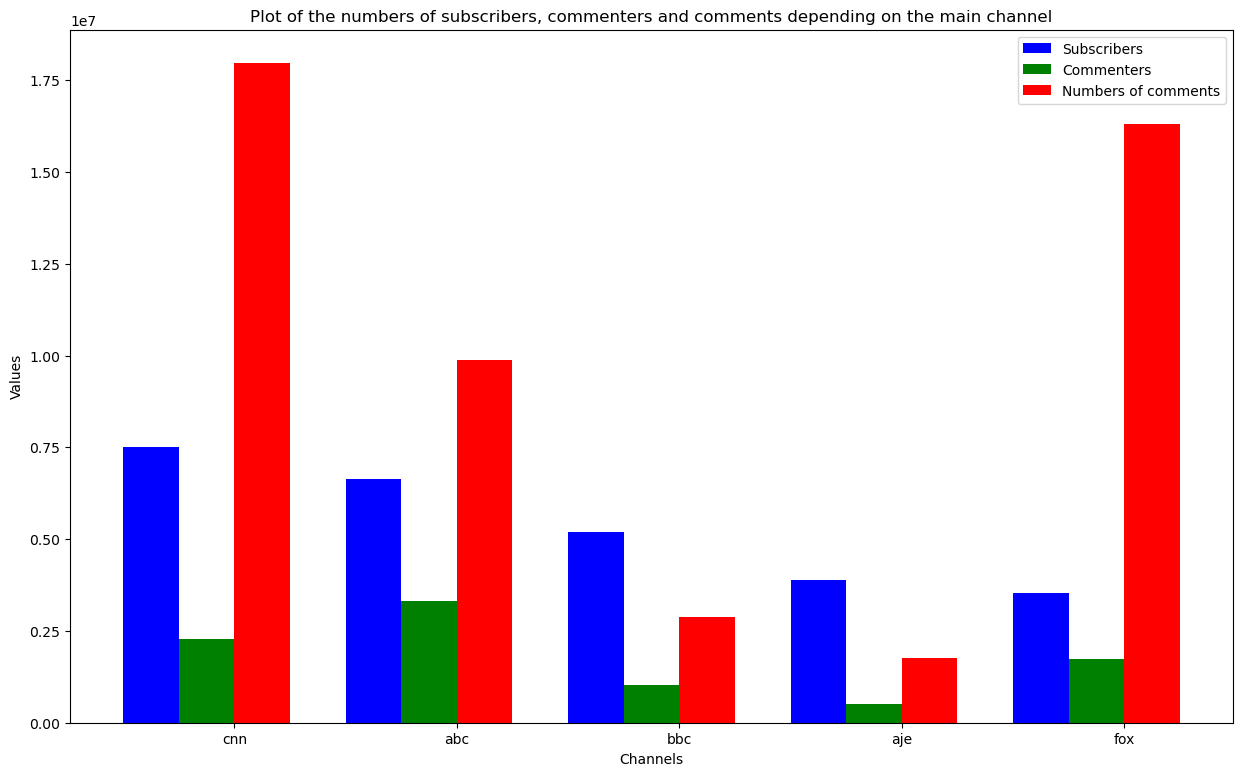

In [24]:
channels = ['cnn', 'abc', 'bbc', 
                'aje', 'fox']
#total numbers of comments
comments = [len(df_comments_news_pol_cnn), 
            len(df_comments_news_pol_abc), 
            len(df_comments_news_pol_bbc), 
            len(df_comments_news_pol_aje), 
            len(df_comments_news_pol_fox)]
#total numbers of subscribers
subscribers = [df_channels_news_pol[df_channels_news_pol.channel == channel_id_cnn].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_abc].subscribers_cc.values[0],
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_bbc].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_aje].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_fox].subscribers_cc.values[0]]
# Calculate the number of unique authors that commented for each dataframe
commenters = [
    df_comments_news_pol_cnn['author'].nunique(),
    df_comments_news_pol_abc['author'].nunique(),
    df_comments_news_pol_bbc['author'].nunique(),
    df_comments_news_pol_aje['author'].nunique(),
    df_comments_news_pol_fox['author'].nunique()
]

# Bar width
bar_width = 0.25
index = np.arange(len(channels))

# Fig
fig, ax = plt.subplots(figsize=(15, 9))

bar1 = ax.bar(index - bar_width, subscribers, bar_width, label='Subscribers', color='blue')
bar2 = ax.bar(index, commenters, bar_width, label='Commenters', color='green')
bar3 = ax.bar(index + bar_width, comments, bar_width, label='Numbers of comments', color='red')

# Labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Values')
ax.set_title('Plot of the numbers of subscribers, commenters and comments depending on the main channel')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(channels)

# Legend display
ax.legend()

plt.show()

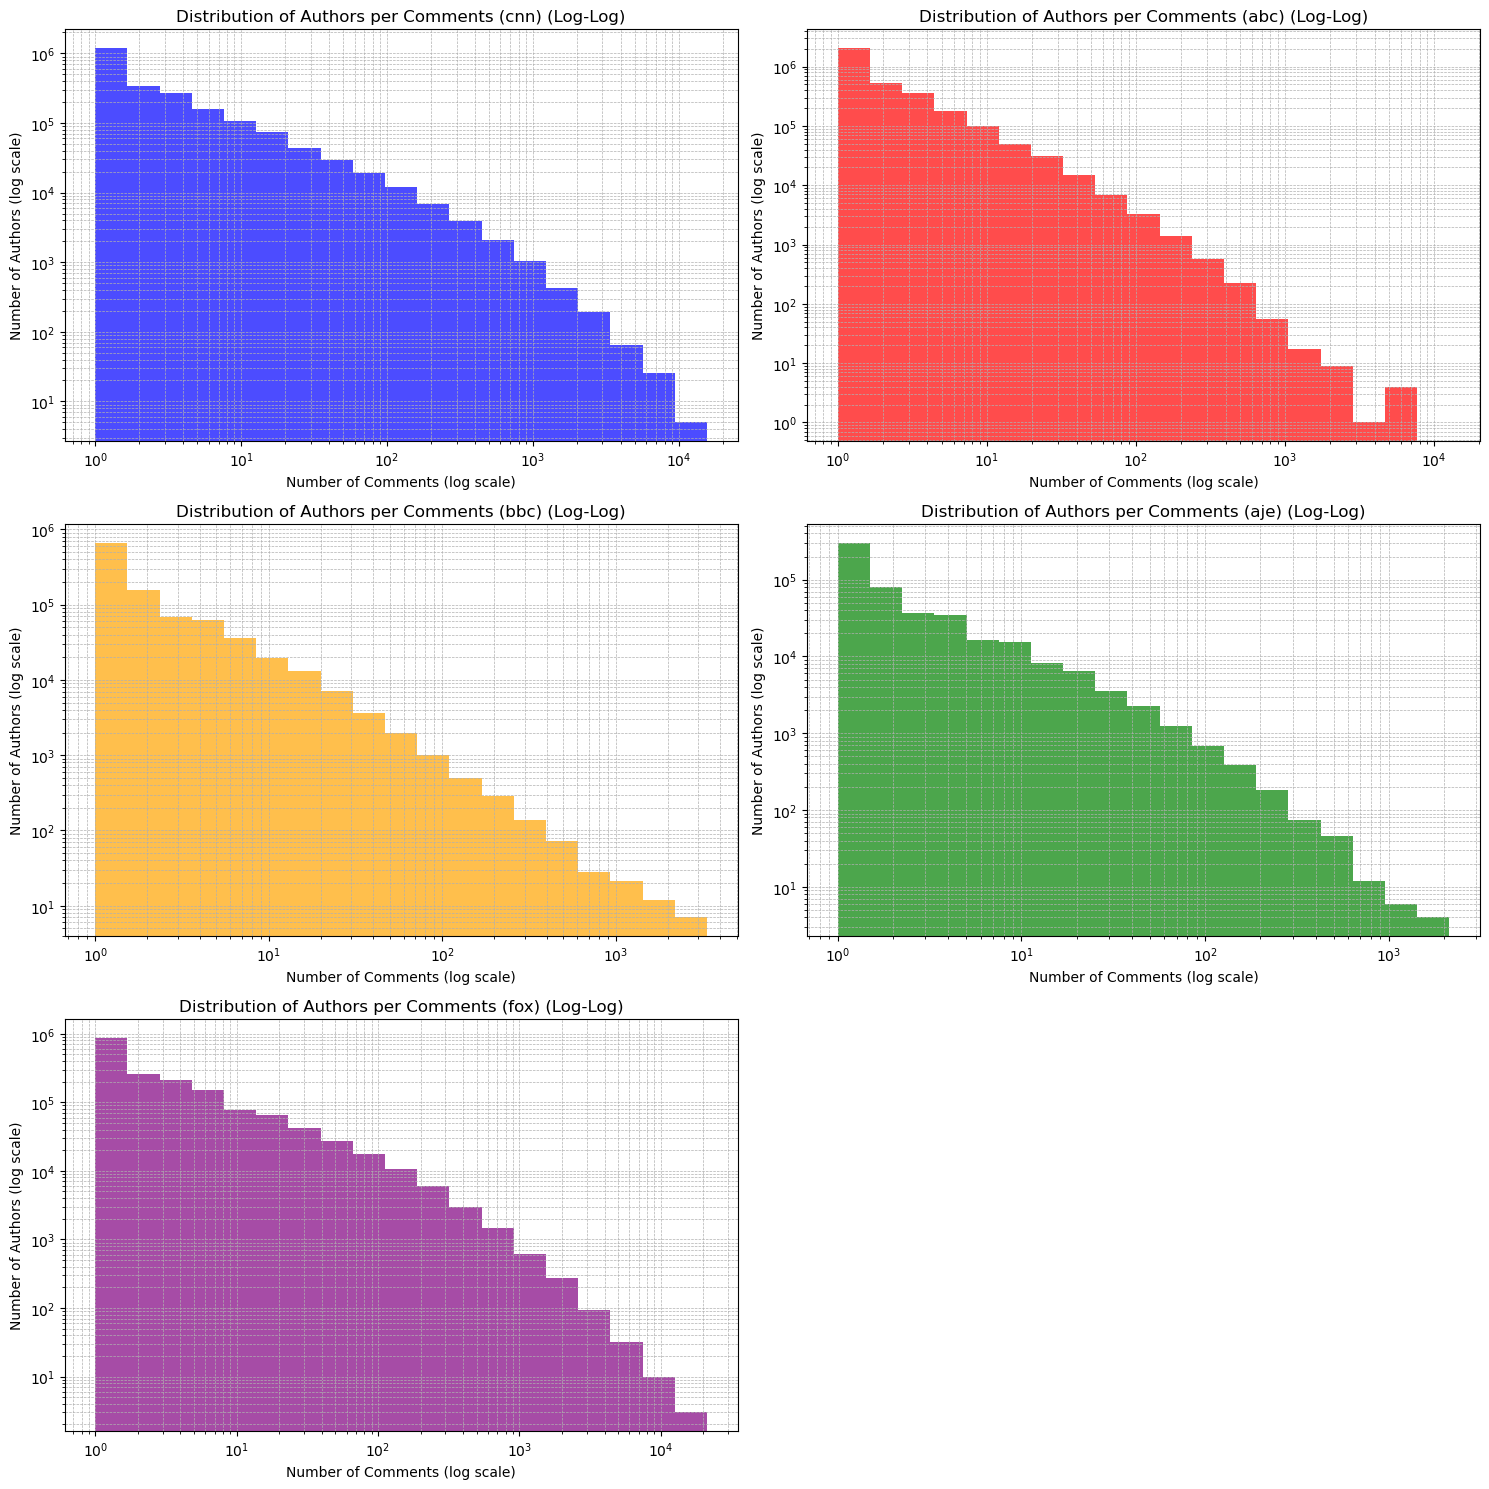

In [25]:
comment_counts_cnn = df_comments_news_pol_cnn.groupby('author').size()
comment_counts_abc = df_comments_news_pol_abc.groupby('author').size()
comment_counts_bbc = df_comments_news_pol_bbc.groupby('author').size()
comment_counts_aje = df_comments_news_pol_aje.groupby('author').size()
comment_counts_fox = df_comments_news_pol_fox.groupby('author').size()

data = [
    (comment_counts_cnn, 'cnn'),
    (comment_counts_abc, 'abc'),
    (comment_counts_bbc, 'bbc'),
    (comment_counts_aje, 'aje'),
    (comment_counts_fox, 'fox')
]
titles = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']
ylims = [15000, 12500, 40000, 500000, 10000]
dp.plot_log_histo_subplot(data, titles, colors, 2)

In [27]:
#returns df with users_id and total number of comments made in a specific channel

threshold = 0  # decide this based on the distributions of comments for the 5 channels

metadata_commenters_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/metadata_commenters_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc", "bbc", 
                    "aje", "fox"]
    ]

if np.all([os.path.isfile(filepath) for filepath in metadata_commenters_news_pol_selected_channels_filepaths]):
    metadata_commenters_news_pol_cnn = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[0])
    metadata_commenters_news_pol_abc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[1])
    metadata_commenters_news_pol_bbc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[2])
    metadata_commenters_news_pol_aje = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[3])
    metadata_commenters_news_pol_fox = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:  # calculate the metadata using the threshold defined above
    # group the comments by channel
    # df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (metadata_commenters_news_pol_cnn,
     metadata_commenters_news_pol_abc,
     metadata_commenters_news_pol_bbc,
     metadata_commenters_news_pol_aje,
     metadata_commenters_news_pol_fox) = (dp.get_metadata_commenters(df_comments, threshold)
                                          for df_comments in [df_comments_news_pol_cnn,
                                                              df_comments_news_pol_abc,
                                                              df_comments_news_pol_bbc,
                                                              df_comments_news_pol_aje,
                                                              df_comments_news_pol_fox])
    
    # save the new dfs to csv
    metadata_commenters_news_pol_cnn.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[0], index=False)
    metadata_commenters_news_pol_abc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[1], index=False)
    metadata_commenters_news_pol_bbc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[2], index=False)
    metadata_commenters_news_pol_aje.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[3], index=False)
    metadata_commenters_news_pol_fox.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[4], index=False)



#putting, for now, a randomn thresold to see if function  is working
#testing for cnn channel
#THIS WAS DONE TO VERIFY THE THRESOLD IS WORKING BUT CAN BE DISCARD OR PUT IN NON IMPORTANT STUFF
metadata_commenters_news_pol_cnn_0_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_0.csv"

try:
    metadata_commenters_news_pol_cnn_0 = pd.read_csv(metadata_commenters_news_pol_cnn_0_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_0 = dp.get_metadata_commenters(df_comments_news_pol_cnn,0)
    metadata_commenters_news_pol_cnn_0.to_csv(metadata_commenters_news_pol_cnn_0_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_0.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_0.shape)

#change thresold 
metadata_commenters_news_pol_cnn_500_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_500.csv"
try:
    metadata_commenters_news_pol_cnn_500 = pd.read_csv(metadata_commenters_news_pol_cnn_500_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_500 = dp.get_metadata_commenters(df_comments_news_pol_cnn,500)
    metadata_commenters_news_pol_cnn_500.to_csv(metadata_commenters_news_pol_cnn_500_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_500.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_500.shape)


Read 5 dfs from file
Read data from file


,author,number_of_comments,number_of_videos
0,269,1,1
1,1015,1,1
2,1548,2,1
3,1560,2,1
4,2097,3,2


(2268335, 3)

Read data from file


,author,number_of_comments,number_of_videos
0,97609,737,631
1,139895,687,581
2,155881,610,334
3,159530,567,384
4,374746,756,656


(3257, 3)

Functions works for the two thresold : 0 and 500, returning different amounts of users, as expected.

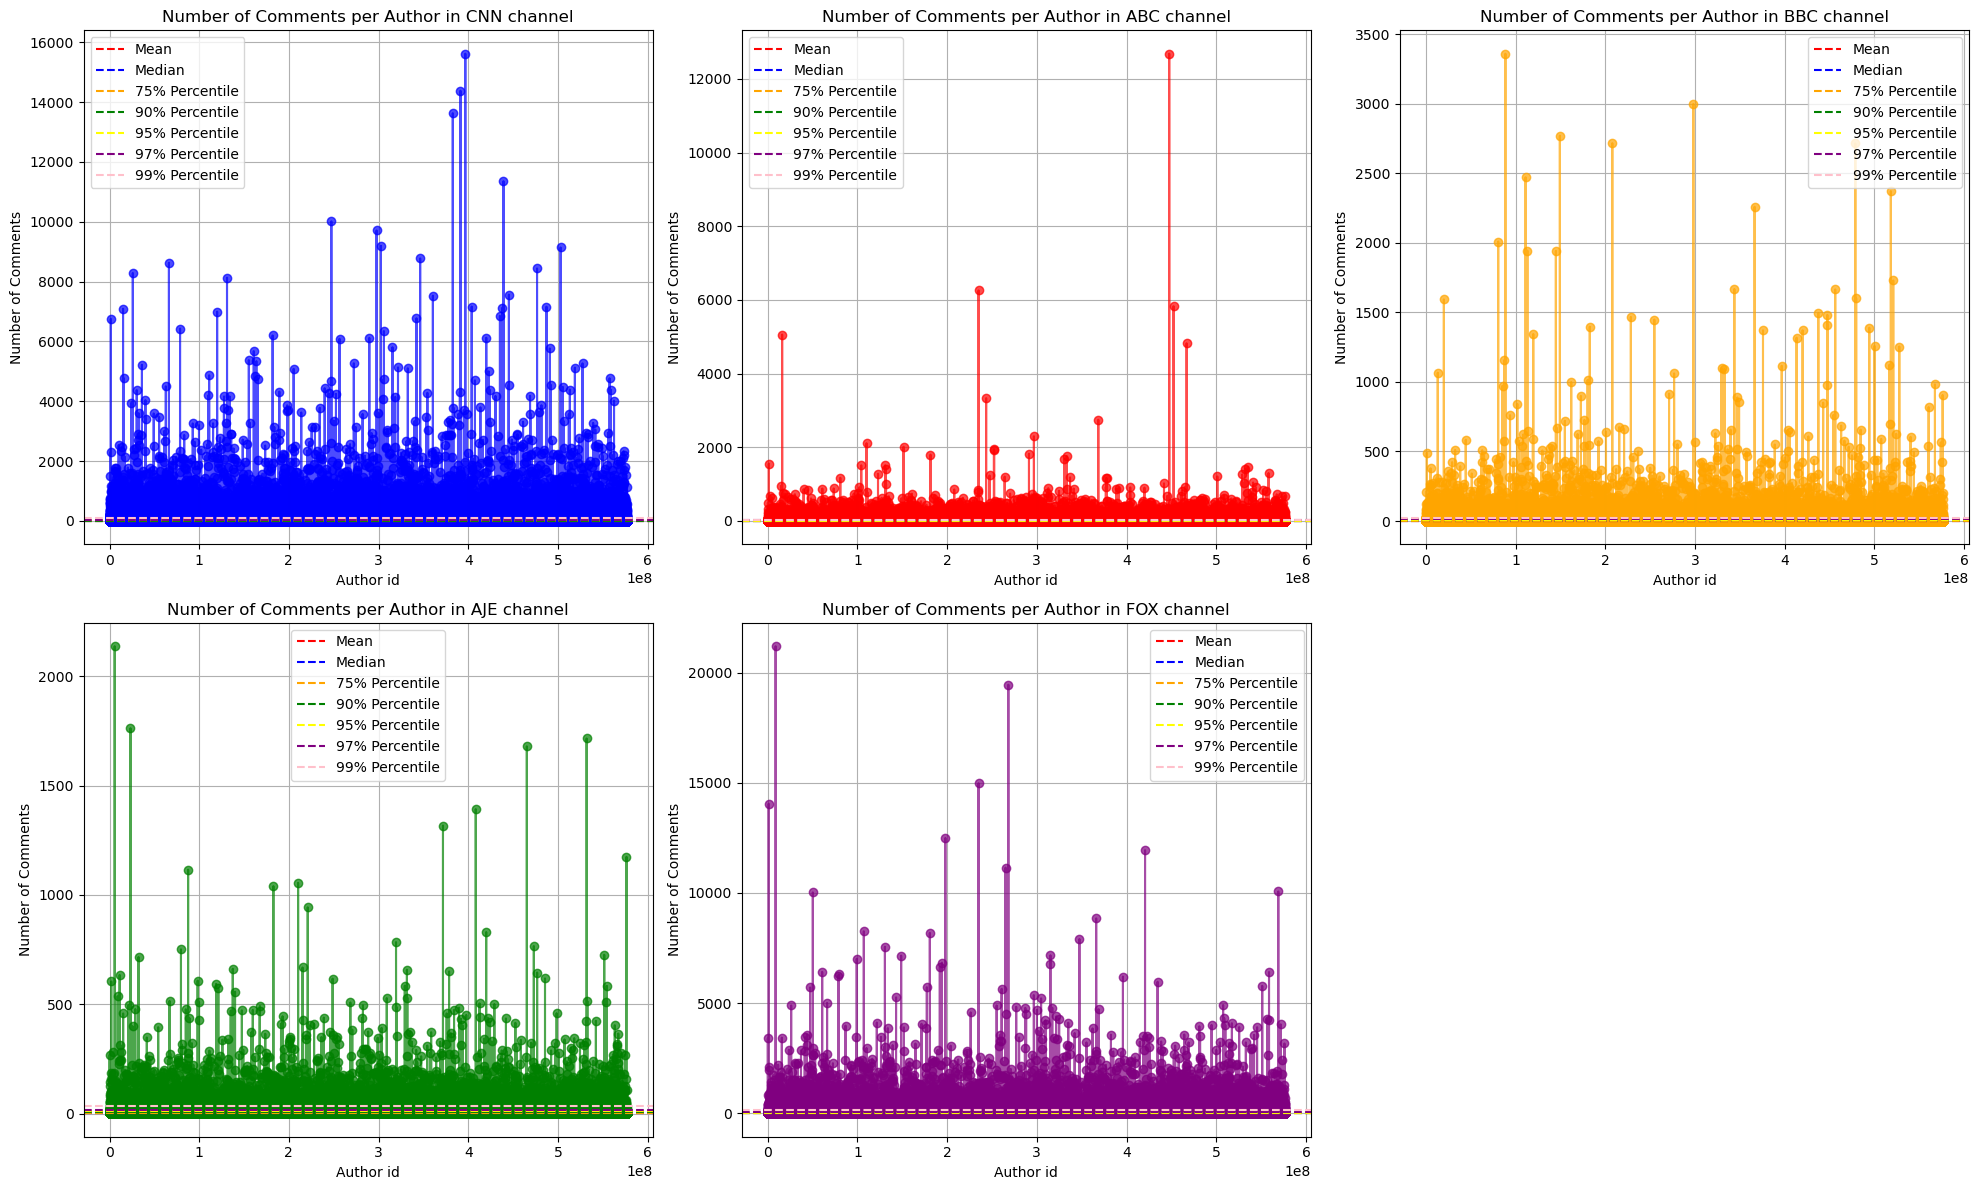

,Mean,Median,75% Percentile,90% Percentile,95% Percentile,97 % Percentile,99% Percentile
cnn,299899,2268335,728636,245623,114279,69177,22895
abc,741751,3322207,1264223,385206,177284,107551,33499
bbc,214495,1028344,370396,107853,55840,31135,10464
aje,89708,506417,126660,54892,25821,16083,5250
fox,230079,871759,484027,174226,89201,52211,17372


In [28]:
#this cell is defining different thresold (median, mean, 95th,99th percentile), and calculating the numbers of users above this number
#the aim is to define which thresold we will take for the cluster (e.g. take 1% top users of cnn that have the most commented)


# Threshold DETERMINATION

#make figure for visualisation for each channel (thus subplot)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# List of 5 main channels
channels = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']

# Dictionary to store metadata for each channel
metadata_dict = {}

# Different types of threshold
thresholds_df = pd.DataFrame(columns=["Mean", "Median", "75% Percentile", 
                                      "90% Percentile" ,"95% Percentile" , 
                                      "97 % Percentile", "99% Percentile"], index=channels)


for idx, channel in enumerate(channels):
    metadata_dict[channel] = {}

    # Get metadata and comment counts for each channel
    metadata_dict[channel]['metadata'] = globals()[f'metadata_commenters_news_pol_{channel}']
    metadata_dict[channel]['comment_counts'] = globals()[f'comment_counts_{channel}']

    # Calculate thresholds for each channel
    mean_channel = metadata_dict[channel]['metadata'].number_of_comments.mean()
    median_channel = metadata_dict[channel]['metadata'].number_of_comments.median()
    percentile_75 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.75)
    percentile_90 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.9)
    percentile_95 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.95)
    percentile_97 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.97)
    percentile_99 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.99)

    # Number of users above the threshold for each channel
    metadata_dict[channel]['metadata_mean'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], mean_channel)
    metadata_dict[channel]['metadata_median'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], median_channel)
    metadata_dict[channel]['metadata_percentile_75'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_75)
    metadata_dict[channel]['metadata_percentile_90'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_90)
    metadata_dict[channel]['metadata_percentile_95'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_95)
    metadata_dict[channel]['metadata_percentile_97'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_97)
    metadata_dict[channel]['metadata_percentile_99'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_99)

    thresholds_df.loc[channel] = [
        len(metadata_dict[channel]['metadata_mean']),
        len(metadata_dict[channel]['metadata_median']),
        len(metadata_dict[channel]['metadata_percentile_75']),
        len(metadata_dict[channel]['metadata_percentile_90']),
        len(metadata_dict[channel]['metadata_percentile_95']),
        len(metadata_dict[channel]['metadata_percentile_97']),
        len(metadata_dict[channel]['metadata_percentile_99'])]
    
    # Plotting the number of comments per author for each channel
    axes[idx].plot(metadata_dict[channel]['comment_counts'].index, metadata_dict[channel]['comment_counts'], marker='o', color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'Number of Comments per Author in {channel.upper()} channel')
    axes[idx].set_xlabel('Author id')
    axes[idx].set_ylabel('Number of Comments')
    axes[idx].grid(True)
    axes[idx].axhline(y=mean_channel, color='r', linestyle='--', label='Mean')
    axes[idx].axhline(y=median_channel, color='b', linestyle='--', label='Median')
    axes[idx].axhline(y=percentile_75, color='orange', linestyle='--', label='75% Percentile')
    axes[idx].axhline(y=percentile_90, color='green', linestyle='--', label='90% Percentile')
    axes[idx].axhline(y=percentile_95, color='yellow', linestyle='--', label='95% Percentile')
    axes[idx].axhline(y=percentile_97, color='purple', linestyle='--', label='97% Percentile')
    axes[idx].axhline(y=percentile_99, color='pink', linestyle='--', label='99% Percentile')
    axes[idx].legend()


plt.tight_layout()
axes[5].axis('off')
plt.show()



display(thresholds_df)


We will take the thresold :99th percentile, as it is already a big set of users. It is statistically relevant because it is taking the most active 1% users for each channels. 

In [29]:
#generate the clusters for each channel, taking only the 1% top users
#cluster 

filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 

    cluster_cnn = metadata_dict['cnn']['metadata_percentile_99']
    cluster_abc = metadata_dict['abc']['metadata_percentile_99']
    cluster_bbc = metadata_dict['bbc']['metadata_percentile_99']
    cluster_aje = metadata_dict['aje']['metadata_percentile_99']
    cluster_fox = metadata_dict['fox']['metadata_percentile_99']

    
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

    print("Wrote cluster data to 5 files.")

    
display(cluster_cnn, cluster_abc, cluster_bbc, cluster_aje, cluster_fox)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


,author,number_of_comments,number_of_videos
0,13221,292,3
1,17554,128,56
2,33093,233,94
3,97609,737,631
4,139895,687,581
...,...,...,...
22890,576458921,200,180
22891,576489820,171,7
22892,576498535,153,124
22893,576498815,1138,405


,author,number_of_comments,number_of_videos
0,13217,48,23
1,16863,65,30
2,17554,42,23
3,33985,53,37
4,52185,37,25
...,...,...,...
33494,576456683,168,122
33495,576457863,73,29
33496,576472312,33,2
33497,576517277,164,114


,author,number_of_comments,number_of_videos
0,38628,31,24
1,155881,209,87
2,157971,29,16
3,216669,26,8
4,242788,38,28
...,...,...,...
10459,576457863,39,18
10460,576481725,27,9
10461,576498815,156,58
10462,576504620,25,13


,author,number_of_comments,number_of_videos
0,83683,37,24
1,97609,269,243
2,174608,51,47
3,511454,50,12
4,540267,52,42
...,...,...,...
5245,575956805,42,40
5246,576016221,48,28
5247,576164605,159,82
5248,576277001,1174,382


,author,number_of_comments,number_of_videos
0,110797,176,98
1,155881,3402,1633
2,229428,146,111
3,232887,153,139
4,242318,834,495
...,...,...,...
17367,576357157,694,603
17368,576456683,290,230
17369,576515899,245,15
17370,576519517,242,229


In [30]:
del metadata_dict
print(gc.collect())

9


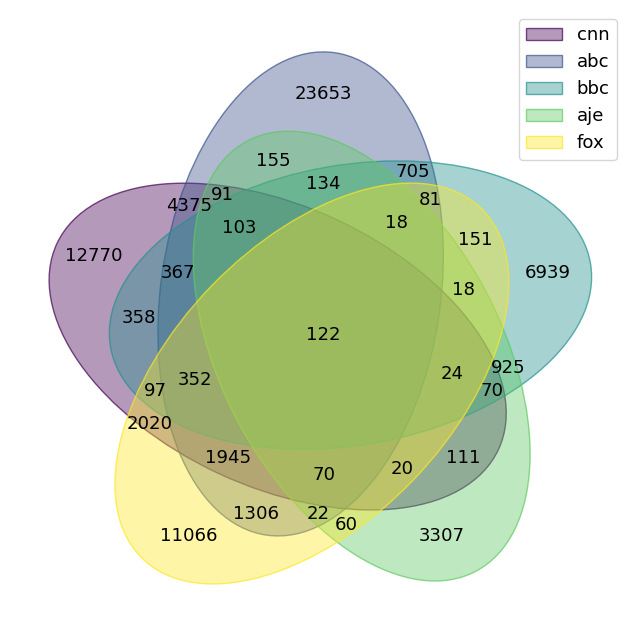

In [31]:
#Venn diagram, in order to see if some authors are in both of some clusters

#venn is a library that take a numbers of set and manipulate it to do a venn diagram of more than 3 sets (matplotlib only do up to 3 sets)
import venn
%matplotlib inline
#define set of users because that's what venn diagram take 
set_cnn = set(cluster_cnn.author)
set_abc = set(cluster_abc.author)
set_bbc = set(cluster_bbc.author)
set_aje = set(cluster_aje.author)
set_fox = set(cluster_fox.author)
sets = {
    "cnn": set_cnn,
    "abc": set_abc,
    "bbc": set_bbc,
    "aje": set_aje,
    "fox": set_fox
}

venn.venn(sets)
plt.show()

### Analysis
One can see that only 122 users are the most active in all 5 channels! Some other overlaps between channels can be seen, but there is still a high number of users that are specific to only one.


# Part 3 : Identifying bubbles

## Determining the mean pairwise overlap of commented videos for users in our clusters

Here, we are going to get, for each defined cluster, for each pair of users in the clusters, the lists of videos they have commented on. Then we compare these lists to get the common elements, i.e. videos on which both paired users have commented on. We can then divide this by the shortest length among the two lists of videos, thereby getting the fraction of commented videos the paired users have in common. We call this "pairwise overlap of commented videos".

Then, we can for instance calculate the mean pairwise overlap for all users in each cluster, and compare this among the clusters. In particular, we can use a random sample of YouTube users, define it as a control cluster, and calculate its the mean pairwise overlap as well. By comparing the control mean overlap to the values for each of our original clusters, we can see whether we have a higher mean for users that commented frequently under a specific channel than for a random reference sample of users; suggesting that they might have a larger overlap in their interests or at least YouTube watching behaviour.

### Getting the required data

*OLD TEXT AND FUNCTION, WE DON'T REALLY NEED IT ANYMORE*

First, we will need to get for every clustered user the list of video they have commented on.

For this, we have the below function, which takes a dataframe with comment data and a list of users, and returns a dataframe containing one column with the user ids and one column with the lists of videos on which the corresponding user has commented on.

There are however too many comments in news and politics videos to be handled at once, so it needs to be done in chunks. Combining the video lists from the different chunks to a single dataframe still needs to be implemented. But, we show that the function below works on a single dataframe by running it on the first chunk of the cnn comment data.


In [32]:
def get_video_list_for_given_users(comment_data: pd.DataFrame, users: pd.DataFrame, video_ids: pd.DataFrame)-> pd.DataFrame:
    """
    Creates a df with one column for users 
    and one column with the list of videos that user has commented on.
    Args:
        comment_data: a df containing the comments to go through
        users: the list of users to do this for
        
    Returns:
        df as described above
    """
    
    comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
    video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']

    return pd.DataFrame({'author': video_ids_of_comments_by_given_users_grouped.groups.keys(), 
                         'video_list': [comment_data.loc[vid_ids].video_id for vid_ids in video_ids_of_comments_by_given_users_grouped.groups.values()]})


video_list_for_cnn_cluster__chunk_1_filename = dataset_root_path + "../generated_data/video_list_cnn_cluster_chunk_1.json"

if os.path.isfile(video_list_for_cnn_cluster__chunk_1_filename):
    df_video_list_for_cnn_cluster_chunk_1 = pd.read_json(video_list_for_cnn_cluster__chunk_1_filename)
else:
    for i, df_comments_news_pol_chunk in enumerate(pd.read_csv(comments_news_pol_videos_filepath, chunksize=1000000)):
        if i > 0:
            break
        df_video_list_for_cnn_cluster_chunk_1 = get_video_list_for_given_users(df_comments_news_pol_chunk, df_comments_news_pol_cnn.author, df_videos_news_pol_display_ids)
        
        df_video_list_for_cnn_cluster_chunk_1.to_json(video_list_for_cnn_cluster__chunk_1_filename, index=False)
        
    
display(df_video_list_for_cnn_cluster_chunk_1)

,author,video_list
0,269,"{'68': '1TV6JFxMEcI', '69': 'BuQBRtxw-CY', '70..."
1,1015,"{'219': 'b8Jmjloz9_k', '220': 'slXbw677sEY'}"
2,1548,"{'336': '-rN17xNnIyM', '337': '-rN17xNnIyM', '..."
3,1560,"{'345': 'LHoQm8LxEmQ', '346': 'LHoQm8LxEmQ', '..."
4,2097,"{'421': 'IwczRAkQsB4', '422': '5Mp8PNm25gk', '..."
...,...,...
5671,1408976,"{'999259': 'fkSNyrByMQw', '999260': 'A2nklduvT..."
5672,1409369,"{'999391': 'cTwxnUKhF5I', '999392': 'CvnmSRghd..."
5673,1409488,"{'999557': '3X59ndYGMqU', '999558': '6YRs-x7LP..."
5674,1409658,"{'999830': 'wRO9BHbF9GA', '999831': 'ACUmAmWaK..."


It's difficult to make a dataframe with the video ids as rows, the user ids as columns, and the entries as booleans showing whether the user has commented on the video, even though it would be a useful format; as this dataframe would be far too big for the amount of videos and users we're considering at this stage.

But, we can save this information in a sparse matrix instead! This matrix contains only stores those values which are True (the case when a user *has* commented on a video), and all other entries are implied to be False. As any user will only have commented on a small fraction of all News and politics videos, this will take far less memory.

In [33]:
def get_video_user_comment_matrix(comment_data: pd.DataFrame, users: pd.DataFrame, print_time_every: int = 0)-> pd.DataFrame:
     """
     Creates a df with video ids as rows, user ids as columns, and the entries being booleans showing whether the user has commented.
     and one column with the list of videos that user has commented on.
     Args:
         comment_data: a df containing the comments to go through. 
             Video_id must be integers, corresponding to the assumed ordering of video ids in the matrix!
             (So for example, you would have to change video ids ['abc', 'xyz', 'pqr'] to [0, 1, 2], 
             and then change the video id column in the comment data to show, 0, 1, or 2 instead of 'abc', 'xyz' or 'pqr')
         users: the list of users to do this for. The user ids MUST be integers corresponding to their respective columns in the matrix
     Returns:
         df as described above
     """

     comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
     video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']
 
     rows = []
     cols = []
     time_duration_avg = 0
     for i, (user, vid_indices) in enumerate(video_ids_of_comments_by_given_users_grouped.groups.items()):
         time_start = time.time()

        # new row ids are the video ids of the videos the user has commented on
         new_row_ids = comment_data.loc[vid_indices].video_id.values
         rows.extend(new_row_ids)

        # new col ids are simply the column corresponding to the current user. That's why the user id's must correspond to their column ids!
         cols.extend([user] * len(new_row_ids))
        
        
         time_end = time.time()
         # Some timing stuff, not used anymore since the code has gotten fast enough
         if not not print_time_every:
             time_duration = time_end - time_start
             time_duration_avg = (time_duration_avg * i + time_duration) / (i+1)
             time_left_in_chunk_avg = (len(video_ids_of_comments_by_given_users_grouped.groups) - i) * (time_duration_avg)
             if i % print_time_every == 0:
                 print(f"    User {i} of {len(video_ids_of_comments_by_given_users_grouped.groups)}: {time_duration:.3f} s ({time_duration_avg:.3f} s avg)   |   " 
                     + f"{time_left_in_chunk_avg:.3f} s ({time_left_in_chunk_avg / 60:.3f} min) left.")

     return rows, cols

For this, there is now a function in the utils file called 'get_video_user_entry_data_for_chunk', which takes comment data and a list of users (i.e., a cluster), and returns the raw data needed to create a sparse boolean matrix where each entry $(i,j)$ indicates whether user $j$ has commented on video $i$.

"Raw data" in this case means: A list of row indices and a list of column entries. The sparse matrix will then be formed such that each pair $(row[k], col[k])$ is a True entry.

However this function only works on single dataframes of comment data, and our comment data (all comments under videos in News and politics) is too big, and we need to read it in chunks.

There is a function 'get_video_user_matrix' in the utils file as well which does this automatically.

There are also further preparation steps which needs to be done, as the functions don't work with the normal video_ids and user_ids; instead they require the id's to correspond to the column and row ids in the matrix.
For example: If the video with id "eh743jss" is in row 312 of the matrix, then the video_id given in the comment data should not be "eh743jss" as it was originally, but it should instead be 312.

(The reason for this is that otherwise, the functions would need to do very time-consuming operations, because for every video they would need to look up in which row it should put a True value. Now instead, it can just put the true value in the row corresponding to the index, no lookup needed)

This is all shown in an example below:

In [34]:
# We create test datasets, to show how the function dp.get_video_user_entry_data_for_chunk works:

# here are a bunch of comments, users and videos we will look at
comments_test = pd.DataFrame({'author':[1, 2, 3, 1, 5, 4, 1], 
                              'video_id':['a', 'b', 'c', 'd', 'e', 'f', 'a']})

users_test = pd.DataFrame({'author': [1, 2, 3, 5]})  
# note that one of the users in the comment data is not part of the user list. This corresponds e.g. to the comment data containing data about comments that were written by someone not in our cluster

videos_test = pd.DataFrame({'display_id': ['a', 'b', 'c', 'd', 'e', 'f']})

print('comments')
display(comments_test)
print('users')
display(users_test)
print('videos')
display(videos_test)

comments


,author,video_id
0,1,a
1,2,b
2,3,c
3,1,d
4,5,e
5,4,f
6,1,a


users


,author
0,1
1,2
2,3
3,5


videos


,display_id
0,a
1,b
2,c
3,d
4,e
5,f


Note that the function above requires the user ids and video ids to correspond to the row and column id's in the matrix

Normally, this will not be the case, for instance, the video ids in the dataset are strings, and while the user ids
are integers, they don't start with 1, and alo we only care about the users in our cluster, so we don't want a column
for other users in our matrix, meaning that we need to assign new indices for the users, 
going from 0 to [number of users in cluster]

This is also true for our example data above, where the display id's are strings and the user id's start at 1, and user 5 is not included in our user list although a comment by user 5 is in the comment data.

Therefore, we are doing a re-indexing:

In [35]:
# take all the available display_ids, remove any duplicates, 
# create a new int index starting from 0, then set the old display id's as index
videos_test_display_id_mapping = (videos_test.display_id  # take the current display ids
    .drop_duplicates()  # remove any diplicates if there are some
    .reset_index(drop=True)  # create a new index which goes from 0 to number of authors (this is stored in the index) (we don't need the old index, so drop=True)
    .reset_index()  # reset index again, in order to move the just created index into a column (with name 'index')
    .set_index(['display_id'])['index'] # set the old display id to be the index, select the new index column
    )  

# This gives a Series which maps each old display id (which is the index of the series) to a new index 
# (which are the values of the Series)
# It looks like this:
print("Video id to int mapping:")
display(videos_test_display_id_mapping)

# Now do the same for user ids and display (take all users in the user list (e.g. a cluster) and give them nice indices)
users_test_user_id_mapping = (users_test.author
                              .drop_duplicates()
                              .reset_index(drop=True)
                              .reset_index()
                              .set_index(['author'])['index']
                              )

print("User id to int mapping:")
display(users_test_user_id_mapping)

# There is a function in the utils file which does this automatically:

videos_test_display_id_mapping = dp.get_int_mapping(videos_test.display_id)
users_test_user_id_mapping = dp.get_int_mapping(users_test.author)

print("Video id to int mapping:")
display(videos_test_display_id_mapping)
print("User id to int mapping:")
display(users_test_user_id_mapping)

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64


Now we can use these mappings to change the user and video ids in our example datarames:

In [36]:
comments_test.author = comments_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in comment data
users_test.author = users_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in the user list
comments_test.video_id = comments_test.video_id.map(videos_test_display_id_mapping)  # correct the video ids in the comment df
videos_test.display_id = videos_test.display_id.map(videos_test_display_id_mapping)  # correct the video ids in the video df

# Look at the results, now we have correct indices!
display(comments_test)
display(users_test)
display(videos_test)

,author,video_id
0,0.0,0
1,1.0,1
2,2.0,2
3,0.0,3
4,3.0,4
5,NaN,5
6,0.0,0


,author
0,0
1,1
2,2
3,3


,display_id
0,0
1,1
2,2
3,3
4,4
5,5


Note that in the comment data, we now have a NaN value, and the numbers are now numpy floats instead of integers.
This both comes from the fact that our mapping does not include a value for user 5, as we don't want to consider this user, and therefore they will not get a column in the matrix. 

So this is not a problem, we only have to consider later to convert float values to ints (we cannot do it now, beause NaN is not an int)

In [37]:
# we then use the function to get the indices of rows and columns where we will later set the value to "true":
# that means, we get an array of row indices and an array of column indices, and then always the first row index 
# with the first column index specify a location of a true value, i.e., a video (=row) which has been commented by a user (column)

test_rows_and_cols = dp.get_video_user_entry_data_for_chunk(comment_data=comments_test, users=users_test.author)
display(test_rows_and_cols[0])  # row indices
display(test_rows_and_cols[1])  # column indices

# so in this case, the points (0, 0), (3, 0), (0, 0), (1, 1), (2, 2), (5, 3) will get true values in our matrix
# meaning that user 0 has commented video 0 twice and video 3 once; user 1 has commented video 1, 
# user 2 has commented video 2, user 3 has commented video 5

[0, 3, 0, 1, 2, 4]

[0.0, 0.0, 0.0, 1.0, 2.0, 3.0]

Note that these indices (when we are talking about "user 1" has commented "video 1" etc) are of course our new indices!

We will see two notebook cells further down that they correspond to the matrix entries, as expected.

If we want to get back the original indices, we can reverse the indexing mapping again.
But right now, we don't really need that. Because we are looking for mean pairwise overlap, so what we call the users
and the videos is not important, we just want to know how many videos they generally have in common.

But if we want to do it (for example, later on it might be important to look at which video it actually was) then it can be done like this:

In [38]:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map({new_ind:display_id for display_id, new_ind in videos_test_display_id_mapping.items()}).to_numpy()

display(test_rows_original_index)

test_cols_original_index = pd.Series(test_rows_and_cols[1]).map({new_ind:user_id for user_id, new_ind in users_test_user_id_mapping.items()}).to_numpy()

display(test_cols_original_index)

# There is also a function for this in the utils file:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map(dp.get_inverse_int_mapping(videos_test_display_id_mapping)).to_numpy()
test_cols_original_index = pd.Series(test_rows_and_cols[1]).map(dp.get_inverse_int_mapping(users_test_user_id_mapping)).to_numpy()

display(test_rows_original_index)
display(test_cols_original_index)

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

So this would instead give the row, col pairs (a, 1), (d, 1), (a, 1), (b, 2), (c, 3), (f, 4)

Whis is more easily interpretable as "video a has been commented on by user 1 twice, video d has been commented on by user 1, etc."

In [39]:
# Now we go back to use our row and column data for the "new" indices (the int indices) to generate our sparse matrix 
# (the matrix is basically stored using these lists of row and column indices, 
# any entry corresponding to such an index pair is considered "True", any other entry is "False" 
# (and therefore doesn't have to be stored explicitly)

# first we need a vector containing our matrix data. In this case, all of our data is "True", 
# because we only assign the true values, as every matrix entry which isn't assigned a value is considered to be "False" automatically
data = np.ones_like(test_rows_and_cols[0])  # a vector full of "True", the same length as our list of row indices

# now generate the matrix, by passing the data, and our row and column indices
test_sparse_matrix = scipy.sparse.coo_array((data, (np.array(test_rows_and_cols[0], dtype=int), 
                                                    np.array(test_rows_and_cols[1], dtype=int))
                                                    ), 
                                            dtype=bool)

print('Print sparse matrix:')
display(test_sparse_matrix)  # when displaying the sparse matrix as it is, we don't see anything. That's the point, that makes it take up less apce and memory

print('Print sparse matrix converted to dense (normal) matrix:')
display(test_sparse_matrix.todense())  # using todense, we can get the normal matrix representation. 
# We see that the values correspond to the data we defined above (columns are users, rows are videos, value shows whether the user has commented under the video)

Print sparse matrix:


<5x4 sparse array of type '<class 'numpy.bool_'>'
	with 6 stored elements in COOrdinate format>

Print sparse matrix converted to dense (normal) matrix:


array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [False, False, False,  True]])

## Saving video-author matrices for cluster members

### Set filenames

In [9]:
# filenames where we want to save the video-author matrices for our clusters
# (note they are not csv files but npz files, I think that is a numpy file format)
video_author_matrix_cnn_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_cnn_cluster.npz"
video_author_matrix_abc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_abc_cluster.npz"
video_author_matrix_bbc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_bbc_cluster.npz"
video_author_matrix_aje_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_aje_cluster.npz"
video_author_matrix_fox_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_fox_cluster.npz"

### generate mapping from video id to integer for all videos in News&Pol

In [42]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.
videos_news_pol_display_ids_filepath = dataset_root_path + "../generated_data/videos_news_pol_display_ids.csv"
df_videos_news_pol_display_ids = pd.read_csv(videos_news_pol_display_ids_filepath)
video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)


### Load or generate the video-user matrices for all clusters

In [10]:
comments_news_pol_videos_filepath = dataset_root_path + "../generated_data/comments_news_pol_videos.csv"
# CNN

# if the file exists, load it
if os.path.isfile(video_author_matrix_cnn_cluster_filename):
    video_author_matrix_cnn_cluster = scipy.sparse.load_npz(video_author_matrix_cnn_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_cnn_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_cnn.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_cnn_cluster_filename,
    print_stats=True
                                                               )

# ABC

# if the file exists, load it
if os.path.isfile(video_author_matrix_abc_cluster_filename):
    video_author_matrix_abc_cluster = scipy.sparse.load_npz(video_author_matrix_abc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_abc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_abc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_abc_cluster_filename,
    print_stats=True
                                                               )
    
# BBC

# if the file exists, load it
if os.path.isfile(video_author_matrix_bbc_cluster_filename):
    video_author_matrix_bbc_cluster = scipy.sparse.load_npz(video_author_matrix_bbc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_bbc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_bbc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_bbc_cluster_filename,
    print_stats=True
                                                               )
    
# AJE

# if the file exists, load it
if os.path.isfile(video_author_matrix_aje_cluster_filename):
    video_author_matrix_aje_cluster = scipy.sparse.load_npz(video_author_matrix_aje_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_aje_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_aje.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_aje_cluster_filename,
    print_stats=True
                                                               )

# FOX

# if the file exists, load it
if os.path.isfile(video_author_matrix_fox_cluster_filename):
    video_author_matrix_fox_cluster = scipy.sparse.load_npz(video_author_matrix_fox_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_fox_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_fox.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_fox_cluster_filename,
    print_stats=True
                                                               )
    

Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file


In [45]:
# In order to get a column i, meaning information about which videos user i has watched, do this:
display(video_author_matrix_cnn_cluster.getcol(1))

# or if you need them as a non sparse matrix, use:
display(video_author_matrix_cnn_cluster.getcol(0).toarray())

# (for most operations, we should not need this! It is good to keep using the sparse format when possible)

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 271 stored elements in Compressed Sparse Column format>

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [46]:
# So for example, to get the overlap of two users i and j
# (The answer to the question "How many videos have both user i and user j commented on?"),
# you can do:

common_videos_user1_user5 = video_author_matrix_cnn_cluster.getcol(1).multiply(video_author_matrix_cnn_cluster.getcol(5))

# number of common videos
overlap_user1_user5 = common_videos_user1_user5.sum()

# number of common videos, normalized w.r.t. the average number of videos the two users have commented on
normed_overlap_user1_user5 = overlap_user1_user5 / np.mean(
    [video_author_matrix_cnn_cluster.getcol(1).sum(),  # number of videos user 1 has commented on
     video_author_matrix_cnn_cluster.getcol(5).sum()]) # number of videos user 5 has commented on

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

# There are functions in the utils file which do this automatically:

common_videos_user1_user5 = dp.common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
overlap_user1_user5 = dp.num_common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
normed_overlap_user1_user5 = dp.normed_num_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 3 stored elements in Compressed Sparse Column format>

3

0.001244296972210701

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 3 stored elements in Compressed Sparse Column format>

3

0.004338394793926247

### Creating mappings to recover the original video and user id's

In [47]:
# If we need to recover the original video id, we can use the following mapping:

recover_original_video_id_news_pol = dp.get_inverse_int_mapping(video_ids_news_pol_int_mapping)

# Example:
example_video_ints = pd.Series([1, 4, 5, 8, 9], name='display_id')  # e.g. someone has watched these videos

example_original_video_ids = example_video_ints.map(recover_original_video_id_news_pol)

display(example_original_video_ids)

0    _dIIEMvH86k
1    AbH3pJnFgY8
2    QBuwj_h1SH4
3    HzikGVcKNe4
4    nR7uZZ6yTo4
Name: display_id, dtype: object

In [48]:
# If we need to recover the original user id's, we can use the following mappings:

# CNN
recover_original_user_ids_cnn_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_cnn.author))
# ABC
recover_original_user_ids_abc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_abc.author))
# BBC
recover_original_user_ids_bbc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_bbc.author))
# AJE
recover_original_user_ids_aje_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_aje.author))
# FOX
recover_original_user_ids_fox_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_fox.author))

# example for cnn:
example_user_ints_cnn = pd.Series([1, 67, 2, 4, 6], name='author')  # some users from cnn cluster

example_original_user_ids_cnn = example_user_ints_cnn.map(recover_original_user_ids_cnn_cluster)
display(example_original_user_ids_cnn)

0      17554
1    1519212
2      33093
3     139895
4     157869
Name: author, dtype: int64

### Getting the random sample of users
we will not rerun this part

We are selecting a random sample of Youtube commenters in the news and politics category in order to compare our clusters to it.  

In [49]:
#getting the average size of the main channels clusters as size for the control sample
control_size = ((len(cluster_cnn)+len(cluster_abc)+len(cluster_aje)+len(cluster_abc)+len(cluster_fox))/5).__round__()
control_size

22503

In [50]:
#getting the total number of commenters in the NP category

authors_in_news_pol_filename = dataset_root_path + "../generated_data/authors_in_news_pol.csv"

try:
    authors_in_news_pol = pd.read_csv(authors_in_news_pol_filename, header=0, names=['author']) #file with the news and politics author ids  
except FileNotFoundError:
    authors_in_news_pol = []
    for chunk in pd.read_csv(dataset_root_path + "../generated_data/comments_news_pol_videos.csv", chunksize=1000000 ):
            authors_in_news_pol.extend(chunk['author'].unique().tolist())  # Get the author id in each chunck 
    authors_in_news_pol = pd.Series(authors_in_news_pol, name='author')

    authors_in_news_pol.to_csv(authors_in_news_pol_filename, index=False)

num_of_authors_news_pol = len(authors_in_news_pol) #the length of the list corresponds to the number of unique commenters in News and Politics category

print(f"There are {num_of_authors_news_pol} authors in news and politics.")

There are 35870979 authors in news and politics.


In [51]:
#generating a ramdom list of numbers for the control sample, size of the list corresponds to size of the random sample (22503). Those random numbers corresponds
#to the index of the author id in the list of all user ids.
import random

control_sample_indices_filename = dataset_root_path + "../generated_data/control_sample_indices.csv"

try:
    control_sample_indices = pd.read_csv(control_sample_indices_filename)
except FileNotFoundError:
    control_sample_indices = random.sample(range(0,num_of_authors_news_pol), k=control_size)
    control_sample_indices = pd.Series(control_sample_indices)
    control_sample_indices.to_csv(control_sample_indices_filename, index=False)

print(control_sample_indices)

              0
0      29134365
1       3564502
2        368109
3      28604018
4      35813006
...         ...
22498  12802745
22499  21712428
22500  11673466
22501  15169299
22502   3285059

[22503 rows x 1 columns]


In [52]:
#generating the control sample by retriving the author ids corresponding to index given by the random control index generated above
control_sample_author_ids_filename = dataset_root_path + "../generated_data/control_sample_author_ids.csv"

try:
    control_sample_author_ids = pd.read_csv(control_sample_author_ids_filename, header=0, names=['author'])
    print("Read data from file")
except FileNotFoundError:
    control_sample_author_ids = authors_in_news_pol.iloc[control_sample_indices]
    control_sample_author_ids.to_csv(control_sample_author_ids_filename, index=False)

# control_sample_author_ids = [authors[i] for i in control_sample_indexes]
print(control_sample_author_ids)

Read data from file
          author
0      468288768
1       57282344
2        5899015
3      459763367
4      575620371
...          ...
22498  205759766
22499  348934461
22500  187614984
22501  243776679
22502   52790508

[22503 rows x 1 columns]


In [53]:
# get video user matrix for control sample
# filename where we want to save the video-author matrix for the cluster
video_author_matrix_random_sample_filename = dataset_root_path + "../generated_data/video_author_matrix_random_sample.npz"

In [54]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.

video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)

In [55]:
# random sample sparse matrix creation

# if the file exists, load it
if os.path.isfile(video_author_matrix_random_sample_filename):
    video_author_matrix_random_sample = scipy.sparse.load_npz(video_author_matrix_random_sample_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_random_sample = dp.get_video_user_matrix(
    users_to_consider=control_sample_author_ids.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_random_sample_filename,
    print_stats=True
                                                               )


Loaded data from file


## Getting jaccard index matrices

This corresponds to the "pairwise overlap"

### Testing overlap calculations = jaccard index

In [56]:
#comparison between the three functions to get jaccard index to verify their results, tested on small clusters

#troncation of CNN and BBC clusters to have smaller clusters for the test
troncate_matrix_cnn = video_author_matrix_cnn_cluster[:, :5]
troncate_matrix_bbc = video_author_matrix_bbc_cluster[:, :3]

#jaccard index using sklearn function
jaccard_cnn_bbc_sklearn, jaccard_list_cnn_bbc_sklearn = dp.get_jacc_between_two_clusters_and_get_mean_sklearn_function(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_cnn_sklearn, jaccard_list_cnn_cnn_sklearn = dp.get_jacc_between_same_cluster_and_get_mean_sklearn_function(troncate_matrix_cnn,)
print(f"Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is {jaccard_cnn_bbc_sklearn} .")
print(f"Jaccard index within CNN using jaccard_score function from sklearn.metrics is {jaccard_cnn_cnn_sklearn} .")

#jaccard index calculated by hand 
jaccard_cnn_bbc_by_hand, jaccard_list_cnn_bbc_by_hand = dp.get_jacc_between_two_clusters_and_get_mean_by_hand(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_cnn_by_hand, jaccard_list_cnn_cnn_by_hand = dp.get_jacc_between_same_cluster_and_get_mean_by_hand(troncate_matrix_cnn,)
print(f"Jaccard index between CNN and BBC calculated by hand is {jaccard_cnn_bbc_by_hand} .")
print(f"Jaccard index within CNN calculated by hand is {jaccard_cnn_cnn_by_hand} .")

#jaccard index using matrix calculations
df_mean_jaccard_value_test_cnn_bbc = dataset_root_path + "../generated_data/test_jaccard_index_matrix_calculations_different_clusters.csv"
df_mean_jaccard_value_test_cnn = dataset_root_path + "../generated_data/test_jaccard_index_matrix_calculations_same_cluster.csv"
jaccard_cnn_bbc_matrix_calc = dp.get_jacc_between_two_clusters_and_get_mean(matrix_1=troncate_matrix_cnn,
                                                                         matrix_2=troncate_matrix_bbc,
                                                                         users_to_consider_1=recover_original_user_ids_cnn_cluster.iloc[:5],
                                                                         users_to_consider_2=recover_original_user_ids_bbc_cluster.iloc[:3],filename = df_mean_jaccard_value_test_cnn_bbc)
jaccard_cnn_cnn_matrix_calc = dp.get_jacc_between_same_cluster_and_get_mean(troncate_matrix_cnn,filename = df_mean_jaccard_value_test_cnn)
print(f"Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is {jaccard_cnn_bbc_matrix_calc} .")
print(f"Jaccard index within CNN using jaccard_score function from sklearn.metrics is {jaccard_cnn_cnn_matrix_calc} .")




Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is 0.0006492785415590793 .
Jaccard index within CNN using jaccard_score function from sklearn.metrics is 0.004674281805159816 .
Jaccard index between CNN and BBC calculated by hand is 0.0006492785415590803 .
Jaccard index within CNN calculated by hand is 0.0046742818051598075 .
    Jaccard index matrix does not exist yet, generating....
    Done.
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is 0.0006492785488565763 .
Jaccard index within CNN using jaccard_score function from sklearn.metrics is 0.0046742819249629974 .


We have the same results with our 3 ways of calculating the mean jaccard index between two clusters or within one cluster. The most effective method for big clusters is the one using matrix calculations. That's why we will continue with this one for our results.

### Generating mean jaccard index table for 5 main clusters and random sample
We are generating tables containing the mean jaccard index for the different clusters.

Index calculated for a cluster with itself = how close users within a cluster are

Index calculated between two clusters = how close the users between two clusters are = how non-isolated are users in a cluster from users in another

Loaded mean jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.00542,0.002183,0.001241,0.001047,0.002977,0.000034
abc,0.00000,0.001944,0.000956,0.000769,0.001741,0.000053
bbc,0.00000,0.000000,0.001577,0.001197,0.001078,0.000037
aje,0.00000,0.000000,0.000000,0.002042,0.000866,0.000025
fox,0.00000,0.000000,0.000000,0.000000,0.005043,0.000031
rdm,0.00000,0.000000,0.000000,0.000000,0.000000,0.000163


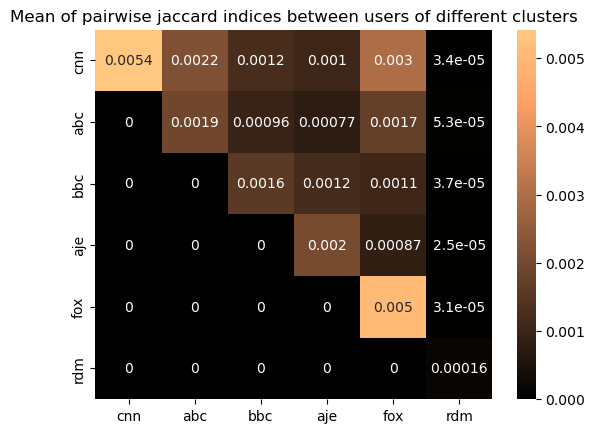

In [57]:
df_mean_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_main_clusters.csv"

try:
    df_mean_jaccard_value_table_main_clusters = pd.read_csv(df_mean_jaccard_value_table_main_clusters_filename,
                                                            index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_mean_jaccard_value_table_main_clusters_filename)

display(df_mean_jaccard_value_table_main_clusters)

sns.heatmap(df_mean_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of different clusters")

### Generating median and other percentile jaccard index table for 5 main clusters + random sample

#### Median

Loaded median jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.003738,0.000867,0.0,0.000000,0.001541,0.0
abc,0.000000,0.000649,0.0,0.000000,0.000553,0.0
bbc,0.000000,0.000000,0.0,0.000000,0.000000,0.0
aje,0.000000,0.000000,0.0,0.000747,0.000000,0.0
fox,0.000000,0.000000,0.0,0.000000,0.003434,0.0
rdm,0.000000,0.000000,0.0,0.000000,0.000000,0.0


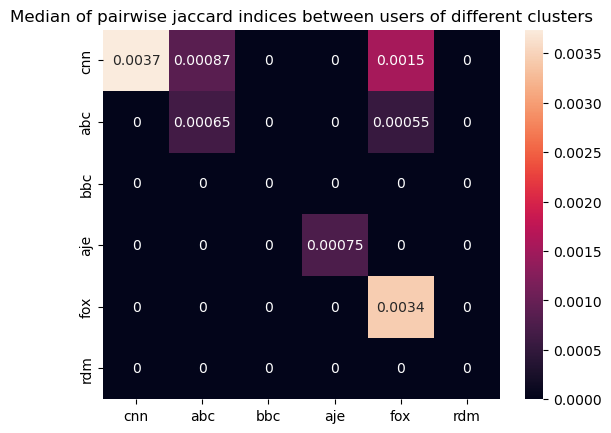

In [58]:
df_median_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/median_jaccard_value_table_main_clusters.csv"

try:
    df_median_jaccard_value_table_main_clusters = pd.read_csv(df_median_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded median jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_median_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_median_jaccard_value_table_main_clusters_filename,
                                                                                mode='percentile',
                                                                                percentile=50.)

display(df_median_jaccard_value_table_main_clusters)

sns.heatmap(df_median_jaccard_value_table_main_clusters, annot=True)
_ = plt.title("Median of pairwise jaccard indices between users of different clusters")

#### 70th percentile

Getting Jaccard matrix for cluster cnn with cluster cnn...
    Loaded jaccard index matrix from file
    Calculating percentile of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster abc...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster bbc...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster aje...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster fox...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster rdm...
    Loaded jaccard index 

,cnn,abc,bbc,aje,fox,rdm
cnn,0.006525,0.002288,0.001074,0.000900,0.003295,0.0
abc,0.002288,0.002196,0.000816,0.000560,0.001744,0.0
bbc,0.001074,0.000816,0.001534,0.001125,0.000961,0.0
aje,0.000900,0.000560,0.001125,0.002147,0.000745,0.0
fox,0.003295,0.001744,0.000961,0.000745,0.006112,0.0
rdm,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


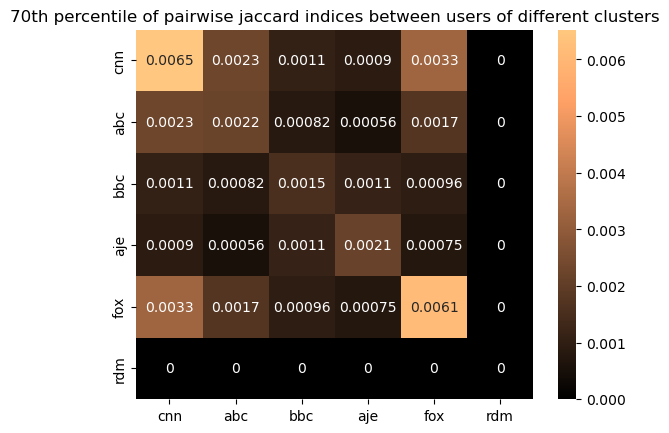

In [59]:
df_70perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/70perc_jaccard_value_table_main_clusters.csv"

try:
    df_70perc_jaccard_value_table_main_clusters = pd.read_csv(df_70perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 70perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_70perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_70perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=70.)

display(df_70perc_jaccard_value_table_main_clusters)

sns.heatmap(df_70perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("70th percentile of pairwise jaccard indices between users of different clusters")

#### 80th percentile

Loaded 80perc jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.008734,0.003559,0.001890,0.001608,0.004848,0.0
abc,0.003559,0.003356,0.001603,0.001279,0.002793,0.0
bbc,0.001890,0.001603,0.002564,0.001964,0.001658,0.0
aje,0.001608,0.001279,0.001964,0.003328,0.001332,0.0
fox,0.004848,0.002793,0.001658,0.001332,0.008216,0.0
rdm,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


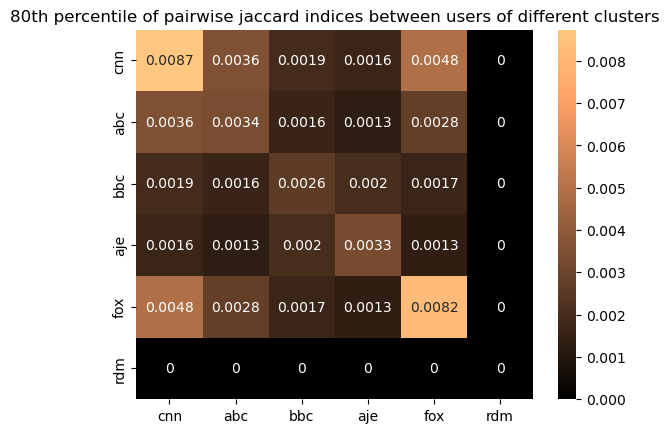

In [47]:
df_80perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/80perc_jaccard_value_table_main_clusters.csv"

try:
    df_80perc_jaccard_value_table_main_clusters = pd.read_csv(df_80perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 80perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_80perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_80perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=80.)

display(df_80perc_jaccard_value_table_main_clusters)

sns.heatmap(df_80perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("80th percentile of pairwise jaccard indices between users of different clusters")

#### 90th percentile

Loaded 90perc jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.012589,0.006067,0.003636,0.003091,0.007772,0.0
abc,0.006067,0.005525,0.002996,0.002454,0.004932,0.0
bbc,0.003636,0.002996,0.004571,0.003575,0.003145,0.0
aje,0.003091,0.002454,0.003575,0.005658,0.002557,0.0
fox,0.007772,0.004932,0.003145,0.002557,0.011846,0.0
rdm,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Text(0.5, 1.0, '90th percentile of pairwise jaccard indices between users of different clusters')

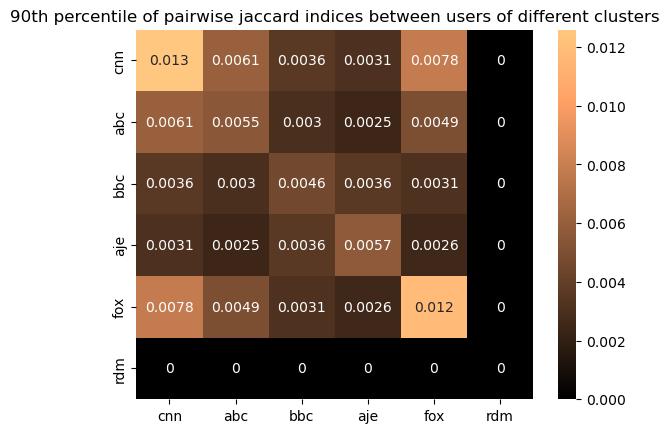

In [46]:
df_90perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/90perc_jaccard_value_table_main_clusters.csv"

try:
    df_90perc_jaccard_value_table_main_clusters = pd.read_csv(df_90perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 90perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_90perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_90perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=90.)

display(df_90perc_jaccard_value_table_main_clusters)

sns.heatmap(df_90perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("90th percentile of pairwise jaccard indices between users of different clusters")

### Generating lin-log and log-log histograms displaying the distribution of the jaccard indices of all pairs within a cluster or between two clusters

In [60]:
users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                            'abc': video_author_matrix_abc_cluster,
                            'bbc': video_author_matrix_bbc_cluster,
                            'aje': video_author_matrix_aje_cluster,
                            'fox': video_author_matrix_fox_cluster,
                            'rdm': video_author_matrix_random_sample}

jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                                           + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                     for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                     for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}

#### Creating separate plots for each cluster combination

Getting Jaccard index histograms for cluster cnn with cluster cnn...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster aje...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster fox...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster rdm...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster aje...
Plots are already existing, skipping...
Getting Jaccard ind

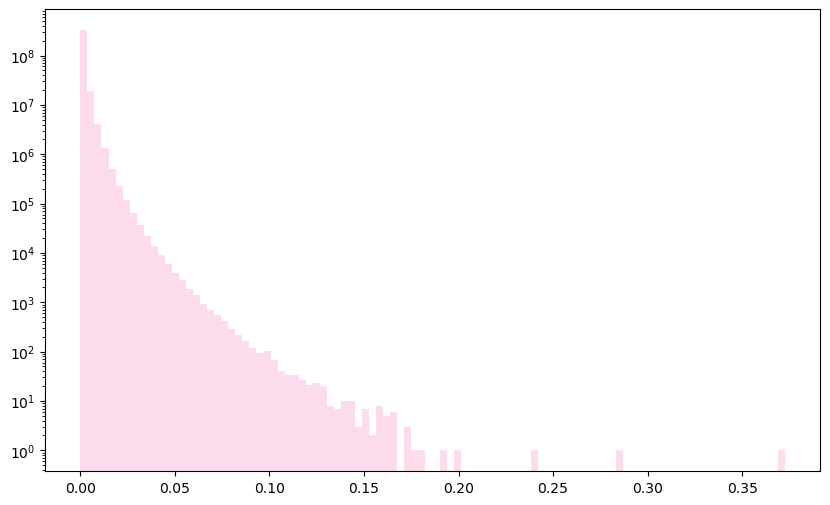

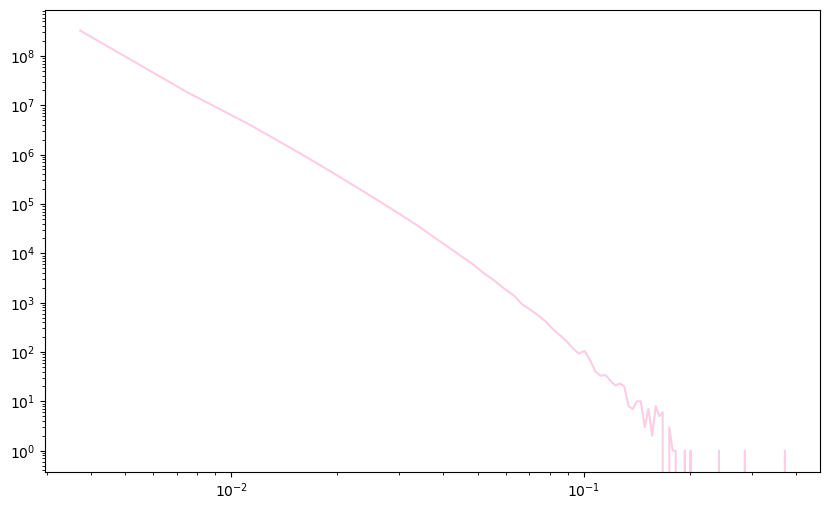

In [ ]:
dp.create_jaccard_index_histograms_for_all_cluster_combinations(video_author_matrices, 
                                                                users_in_clusters, 
                                                                jaccard_filenames,
                                                                base_filename="src/figures/hist_of_pairwise_jacc_index",
                                                                show=True)

#### Creating subplot figures containing histograms for all cluster combinations

Getting Jaccard index histograms for cluster cnn with cluster cnn...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster abc...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster bbc...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster aje...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster fox...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster rdm...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster abc with cluster abc...
Jaccard

/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/src/utils/utils.py:2116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_linlog.show()


Saved loglog plot in file src/figures/subplots_loglog_hist_of_pairwise_jacc_index_test.png.


/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/src/utils/utils.py:2122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loglog.show()


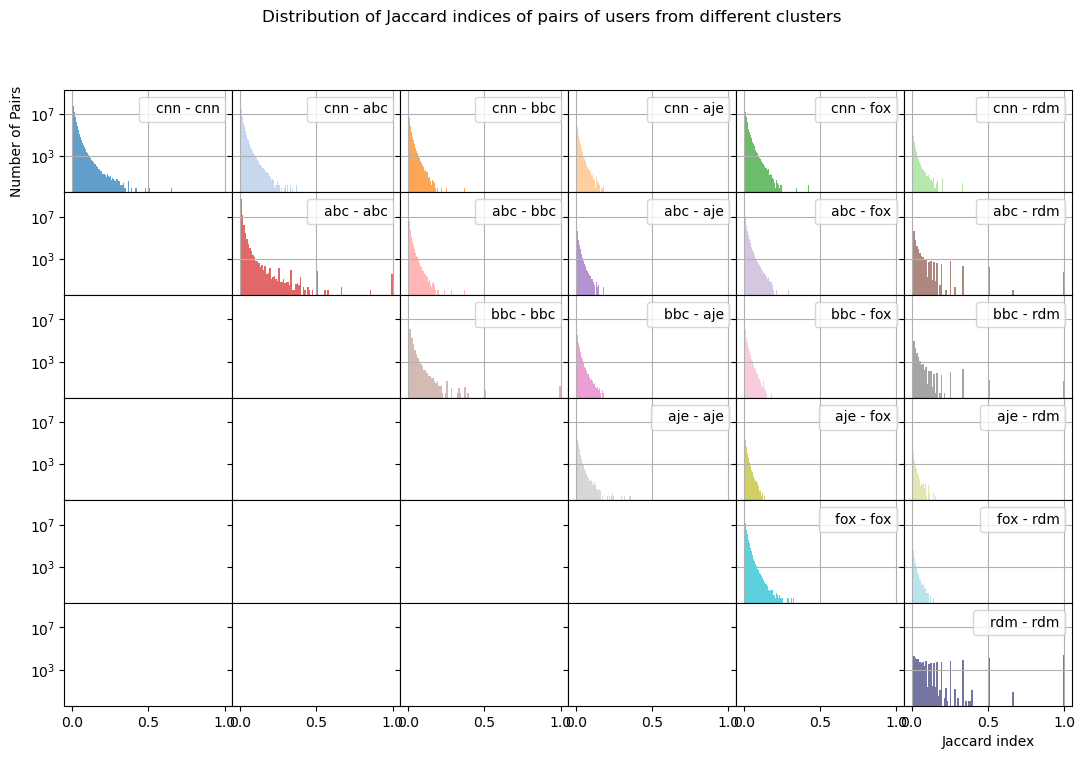

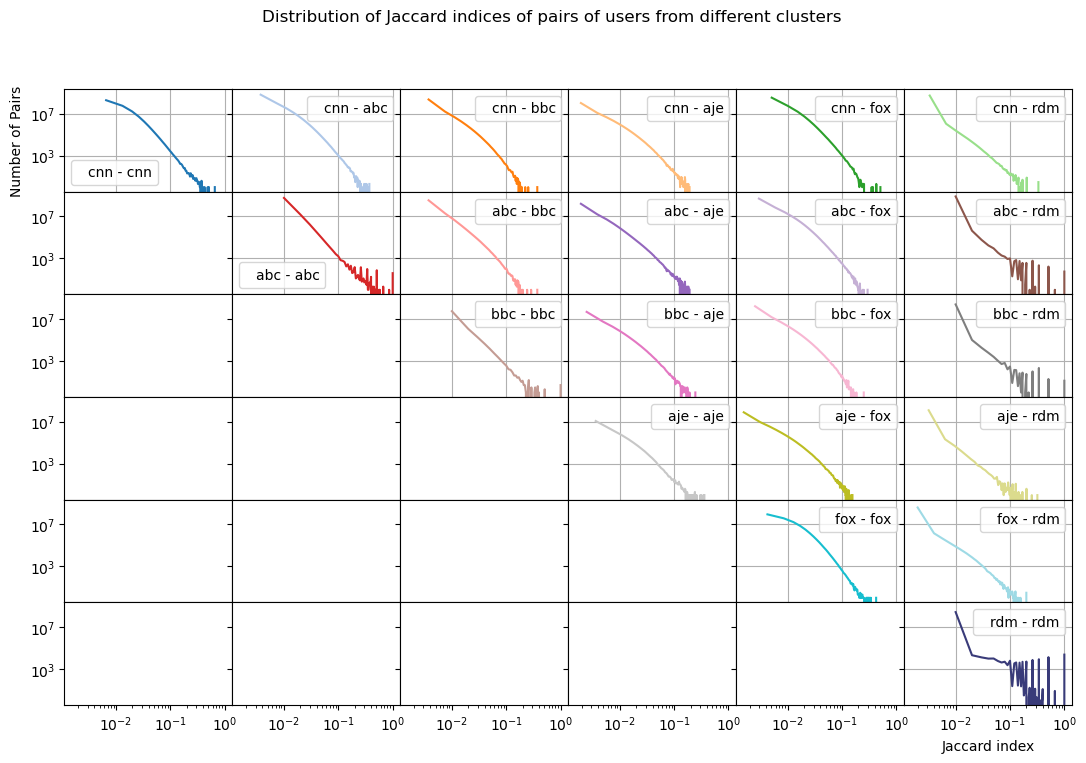

In [17]:
dp.make_subplot_grid_with_jaccard_index_histograms(video_author_matrices, 
                                                   users_in_clusters, 
                                                   jaccard_filenames,
                                                   mode='both',
                                                   linlog_filename="src/figures/subplots_linlog_hist_of_pairwise_jacc_index_test.png",
                                                   loglog_filename="src/figures/subplots_loglog_hist_of_pairwise_jacc_index_test.png",
                                                   show=True)

## Examine whether there are multiple users' bubbles within a cluster

Now we are looking for users' bubbles in the same cluster based on the **similarity of commented videos**, using DBSCAN algorithm. 

Here are the steps :

- Take Andrea's sparse matrix of a cluster (columns = users, rows = videos), where booleans indicate if the user has commented on a video or not

- Transform the sparse matrix to a distance matrix using the Cosine distance method, which returns a jxj matrix ( j = number of users of the cluster ) containing integers between 0-1, which indicate the distance between each pair of users in terms of commenting behavior (0=close=similar, 1=distant=not similar)

- Choose the optimal **min_samples** parameter for DBSCAN, i.e the minimum number of users in a bubble (minimum bubble size).

- Choose the optimal **eps** parameter for DBSCAN, i.e the minimum distance between two users for them to be considered in the same cluster. If eps is too low, many users will be classified as outliers (bubble '-1').

- Run DBSCAN on the distance matrix: what is returned, 'labels', is the assigned bubble for each user (1D list of integers, and '-1' bubble is for outliers). The user id is not specified, but this 'label' list is in the same order as the columns in the input distance matrix.

- Visualize bubbles (I tested PCA, t-SNE, but they aren't very nice. Will try with the Netkokx, which should be much nicer !)

- Generate a sparse matrix (columns = users, rows = videos), like the initil one, but for each bubble. Saved them with paths.


In [61]:
video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                            'abc': video_author_matrix_abc_cluster,
                            'bbc': video_author_matrix_bbc_cluster,
                            'aje': video_author_matrix_aje_cluster,
                            'fox': video_author_matrix_fox_cluster}

In [62]:
# Calculate pairwise distances (cosine distances between users)
# Using the video-author matrix transposed as your input matrix
distance_matrices = {}

for key in video_author_matrices.keys():
    distance_matrix = pairwise_distances(video_author_matrices[key].T, metric='cosine')
    distance_matrices[key] = distance_matrix

In the following cells, we explore users' commenting data in the 5 defined clusters (CNN, ABC, BBC, AJE and FOX) to help us choose the optimal eps and min_samples for further DBSCAN clustering. 

For each cluster, we first have a look at the sparsity between users, then check the max and min (Cosine) distance is.

##### Sparsity of each cluster

In [23]:
for key in video_author_matrices.keys():
    # Measure sparsity of the data
    nonzero_elements = video_author_matrices[key].nnz
    total_elements = video_author_matrices[key].shape[0] * video_author_matrices[key].shape[1]
    sparsity = 1 - (nonzero_elements / total_elements)

    print(f"Sparsity of {key} cluster: {sparsity:.4f}")

    # Adjust DBSCAN parameters based on sparsity
    if sparsity > 0.70:
        print("Data is sparse. Consider smaller eps and min_samples.")
    else:
        print("Data is dense. Consider larger eps and min_samples.")

Sparsity of cnn cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of abc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of bbc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of aje cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of fox cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.


##### Minimum and maximum distance between two users, in each cluster

In [63]:
# Get the minimum and maximum cosine distance values to know in which range EPS has to be
for key in distance_matrices.keys():
    print(key, 'cluster:')
    print(f"Minimum Cosine Distance: {np.min(distance_matrices[key])}")
    print(f"Maximum Cosine Distance: {np.max(distance_matrices[key])}")

cnn cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
abc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
bbc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
aje cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
fox cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0


##### Test DBSCAN clustering with relevant eps/min_samples combinations (on FOX)

First, we try bubbling FOX's users with some eps/min_samples combinations until we obtain a satisfactory result, i.e having some bubbles and not too many outliers.

In [110]:
eps_values = [0.6, 0.8, 0.9]
min_samples_values = [4, 5, 10, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        #count bubbles and outliers
        n_bubbles = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_bubbles} clusters, {n_outliers} outliers")

eps=0.600000, min_samples=4: 0 clusters, 17372 outliers
eps=0.600000, min_samples=5: 0 clusters, 17372 outliers
eps=0.600000, min_samples=10: 0 clusters, 17372 outliers
eps=0.600000, min_samples=50: 0 clusters, 17372 outliers
eps=0.600000, min_samples=100: 0 clusters, 17372 outliers
eps=0.800000, min_samples=4: 8 clusters, 17014 outliers
eps=0.800000, min_samples=5: 5 clusters, 17031 outliers
eps=0.800000, min_samples=10: 3 clusters, 17056 outliers
eps=0.800000, min_samples=50: 2 clusters, 17180 outliers
eps=0.800000, min_samples=100: 0 clusters, 17372 outliers
eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
eps=0.900000, min_samples=5: 6 clusters, 11868 outliers
eps=0.900000, min_samples=10: 3 clusters, 11989 outliers
eps=0.900000, min_samples=50: 1 clusters, 12555 outliers
eps=0.900000, min_samples=100: 1 clusters, 12863 outliers


We can see that min_sample = 50 and 100 give very few bubbles, indicating that the minimum size is too high. We thus continue our tests with 4, 5 and 10, while zooming in eps_values between 0.85 and 0.95.

In [111]:
# added some more values
eps_values = [0.85, 0.88, 0.89, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
min_samples_values = [2, 3, 4, 5, 8, 10, 13, 15, 18, 20, 25, 30, 40, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        #count bubbles and outliers
        n_bubbles = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)
        gc.collect()
        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_bubbles} clusters, {n_outliers} outliers")

eps=0.850000, min_samples=4: 15 clusters, 15963 outliers
eps=0.850000, min_samples=5: 11 clusters, 15985 outliers
eps=0.850000, min_samples=10: 4 clusters, 16109 outliers
eps=0.880000, min_samples=4: 12 clusters, 14200 outliers
eps=0.880000, min_samples=5: 7 clusters, 14240 outliers
eps=0.880000, min_samples=10: 3 clusters, 14356 outliers
eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
eps=0.890000, min_samples=5: 6 clusters, 13174 outliers
eps=0.890000, min_samples=10: 3 clusters, 13310 outliers
eps=0.910000, min_samples=4: 3 clusters, 10239 outliers
eps=0.910000, min_samples=5: 2 clusters, 10274 outliers
eps=0.910000, min_samples=10: 2 clusters, 10390 outliers
eps=0.930000, min_samples=4: 4 clusters, 6149 outliers
eps=0.930000, min_samples=5: 2 clusters, 6177 outliers
eps=0.930000, min_samples=10: 1 clusters, 6288 outliers
eps=0.950000, min_samples=4: 1 clusters, 2012 outliers
eps=0.950000, min_samples=5: 1 clusters, 2024 outliers
eps=0.950000, min_samples=10: 1 clusters, 205

Interesting parameter combinations for FOX:

    eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
    eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
    eps=0.910000, min_samples=4: 3 clusters, 10239 outliers

Parameters chosen for all clusters: 

    eps = 0.9 
    min_samples = 8 (4 was too low for the other clusters)    

In [64]:
opt_eps = 0.9
opt_min_samples = 8

#initialize dict to store labels from dbscan
labels_dict = {}

#initialize dict to store number of bubbles 
n_bubbles_dict = {}

#iterate on the 5 clusters
for key in distance_matrices.keys():

    #define clustring model
    model = DBSCAN(eps=opt_eps, min_samples=opt_min_samples, metric='precomputed')

    #1D array containing the bubble to which each user belongs, in the same order of the users of sparse matrix
    labels = model.fit_predict(distance_matrices[key])  
    
    #add labels to dict
    labels_dict[key] = labels      

    #count the bubbles (excluding outliers)
    unique_bubbles = set(labels) - {-1}  # Exclude the outlier label (-1)
    n_bubbles_dict[key] = len(unique_bubbles)                           

    #print the number of users in each bubble
    bubble_counts = Counter(labels)
    print("Number of users in each bubble,", key, ":")
    for bubble, count in bubble_counts.items():
        if bubble == -1:
            print(f"Outliers: {count} users")
        else:
            print(f"Bubble {bubble}: {count} users")


Number of users in each bubble, cnn :
Outliers: 14326 users
Bubble 0: 8518 users
Bubble 2: 16 users
Bubble 1: 9 users
Bubble 4: 8 users
Bubble 5: 10 users
Bubble 3: 8 users
Number of users in each bubble, abc :
Outliers: 25983 users
Bubble 0: 7238 users
Bubble 8: 16 users
Bubble 20: 6 users
Bubble 7: 9 users
Bubble 13: 9 users
Bubble 2: 36 users
Bubble 12: 26 users
Bubble 16: 6 users
Bubble 14: 5 users
Bubble 1: 15 users
Bubble 11: 8 users
Bubble 9: 5 users
Bubble 6: 10 users
Bubble 3: 13 users
Bubble 19: 18 users
Bubble 21: 6 users
Bubble 4: 7 users
Bubble 22: 7 users
Bubble 10: 18 users
Bubble 5: 6 users
Bubble 23: 10 users
Bubble 18: 9 users
Bubble 15: 11 users
Bubble 17: 7 users
Bubble 24: 5 users
Bubble 25: 10 users
Number of users in each bubble, bbc :
Outliers: 7988 users
Bubble 0: 2254 users
Bubble 12: 19 users
Bubble 1: 59 users
Bubble 19: 9 users
Bubble 3: 8 users
Bubble 5: 9 users
Bubble 4: 8 users
Bubble 2: 8 users
Bubble 14: 4 users
Bubble 11: 10 users
Bubble 6: 10 users
B

#### Trying different visualizations on FOX bubbles (PCA, t-SNE, and Networkx)

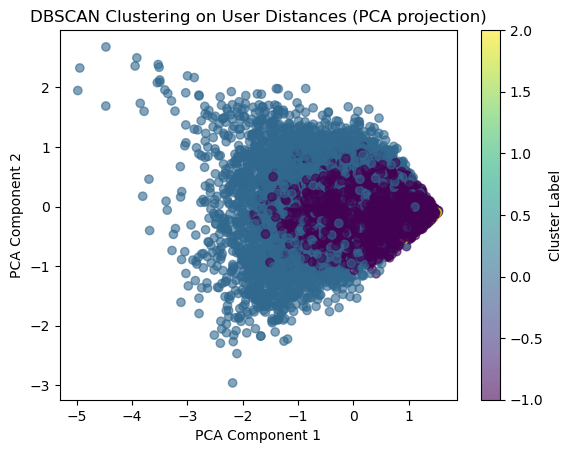

In [114]:
#visualize bubbles using PCA

from sklearn.decomposition import PCA

# Get the distance matrix for a given subset (e.g., for key = 'subset_1')
distance_matrix = distance_matrices['fox']

# Apply PCA to reduce to 2D (or 3D if you prefer)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(distance_matrix)

# Plotting the 2D representation
plt.scatter(pca_result[:, 0][labels_dict['fox'] == -1], pca_result[:, 1][labels_dict['fox'] == -1], c=labels_dict['fox'][labels_dict['fox'] == -1], cmap='viridis', alpha=0.05)
plt.scatter(pca_result[:, 0][labels_dict['fox'] != -1], pca_result[:, 1][labels_dict['fox'] != -1], c=labels_dict['fox'][labels_dict['fox'] != -1], cmap='viridis', alpha=0.9)
plt.title('DBSCAN Clustering on User Distances (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [65]:
from sklearn.manifold import TSNE

distance_matrix = distance_matrices['fox']

# Apply t-SNE to the distance matrix (you can also use PCA first if needed)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(distance_matrix)

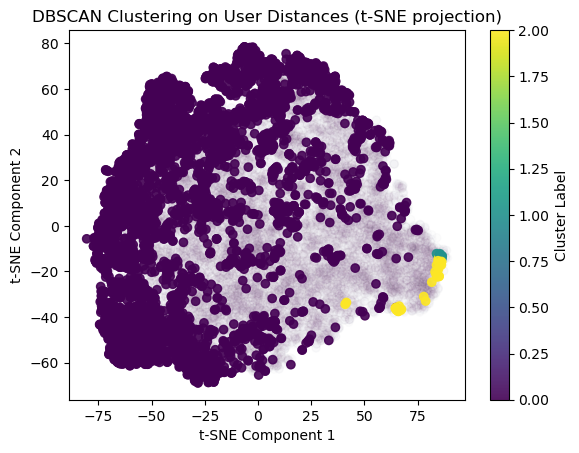

In [66]:
# Plotting the 2D t-SNE result
plt.scatter(tsne_result[:, 0][labels_dict['fox'] == -1], tsne_result[:, 1][labels_dict['fox'] == -1], c=labels_dict['fox'][labels_dict['fox'] == -1], cmap='viridis', alpha = 0.01)
plt.scatter(tsne_result[:, 0][labels_dict['fox'] != -1], tsne_result[:, 1][labels_dict['fox'] != -1], c=labels_dict['fox'][labels_dict['fox'] != -1], cmap='viridis', alpha = 0.9)
plt.title('DBSCAN Clustering on User Distances (t-SNE projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [67]:
#define the dict to store paths
bubbles_paths = {}

#use a dictionary comprehension to generate the paths dynamically
for channel, count in n_bubbles_dict.items():
    paths = []
    for i in range(count):
        path = f"{dataset_root_path}../generated_data/video_author_matrix_{channel}_b{i}.npz"
        paths.append(path)
        bubbles_paths[channel] = paths

##### Generate sparse matrices for each bubble (or read from files)

In [68]:
#define dict to store sparse matrices of the bubbles
bubbles_video_author_matrices = {}

#iterate on clusters 
for key in bubbles_paths.keys():
        print(key)

        #define liste of matrices
        matrices = []

        #iterate on bubbles of the cluster
        for bubble in range(len(bubbles_paths[key])):
                # if the file exists, load it in the dict
                if os.path.isfile(bubbles_paths[key][bubble]):
                        #load and add matrix to list
                        matrices.append(scipy.sparse.load_npz(bubbles_paths[key][bubble]))
                        print(f"Loaded data from file")
                
                # if not, generate it
                else:
                        #get id of bubbles in the cluster
                        bubbles_id = np.unique(labels_dict[key])
                        bubbles_id = bubbles_id[bubbles_id != -1]  # Exclude -1 for outliers

                        #get users of the bubble
                        users = np.where(labels_dict[key] == id)[0]
                        
                        #slice users from the sparse matrix of the cluster
                        matrix = video_author_matrices[key][:, users]

                        #add matrix to list
                        matrices.append(matrix)
                        
                        #save matrix in
                        scipy.sparse.save_npz(bubbles_paths[key][id], matrix)

                        print(f"Saved file {bubbles_paths[key][id]}")

                        print(f"Bubble {id}: {matrix.shape} (videos x users)")

        #add list of matrices to dict 
        bubbles_video_author_matrices[key] = matrices

cnn
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
abc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
bbc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from fil

## Perform pairwise overlap on the bubbles defined by DBSCAN

- Use sparse matrices containing commenting information of the users for bubble computed by Mila. The sparse matrix has columns = users and rows = videos; if a user has commented on a video, the stored value is True. 

- perform pairwise overlaps (same bubble, or different bubbles) using Horti/Andreas code

#### Computing mean pairwise overlap between users of each bubble

In [70]:
#Computing pairwise overlap within each bubble for each channel

channel_averages= dp.average_pairwise_overlap(bubbles_video_author_matrices)

In [10]:
bubbles_video_author_matrices

{'cnn': [<Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 8814943 stored elements and shape (7551328, 8518)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 4068 stored elements and shape (7551328, 9)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 27043 stored elements and shape (7551328, 16)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 19752 stored elements and shape (7551328, 8)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 3648 stored elements and shape (7551328, 8)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 4547 stored elements and shape (7551328, 10)>],
 'abc': [<Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 5734082 stored elements and shape (7551328, 7238)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 17770 stored elements and shape (7551328, 15)>,
  <Compressed Sparse Column sparse matrix of dtype 'bool'
  	with 2180 

In [22]:
jaccard_filenames_bubbles = {channel: [dataset_root_path + f"../generated_data/jaccard_matrix_{channel}_b{i}.npy" for i in range(len(bubbles_paths[channel]))] for channel in bubbles_paths.keys()}

mean_jaccard_values_bubbles = {channel: [] for channel in bubbles_paths.keys()}

for channel, channel_bubble_matrices_list in bubbles_video_author_matrices.items():
    for i, matrix in enumerate(channel_bubble_matrices_list):
        filename = jaccard_filenames_bubbles[channel][i]

        mean_jacc_index_for_bubble = dp.get_jacc_between_same_cluster_and_get_mean(matrix, filename=filename)
        mean_jaccard_values_bubbles[channel].append(mean_jacc_index_for_bubble)
        print(f"Mean jacc index for channel {channel}, bubble number {i}: {mean_jacc_index_for_bubble}")


    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 0: 0.009957614354789257
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 1: 0.10993573069572449
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 2: 0.027064021676778793
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 3: 0.042074985802173615
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 4: 0.037406861782073975
    Loaded jaccard in

In [29]:
for channel, mean_jacc_list in mean_jaccard_values_bubbles.items():
    print(channel)
    print(pd.Series(mean_jacc_list).sort_values())

cnn
0    0.009958
2    0.027064
5    0.031368
4    0.037407
3    0.042075
1    0.109936
dtype: float32
abc
0     0.002734
7     0.009910
4     0.010983
12    0.011155
19    0.011183
2     0.011579
9     0.012697
24    0.012972
15    0.013317
5     0.013949
25    0.018152
22    0.018224
23    0.019603
20    0.021681
16    0.024361
21    0.028035
8     0.028141
17    0.034375
1     0.035183
10    0.036413
13    0.037862
14    0.040105
11    0.041026
6     0.042533
18    0.044521
3     0.102670
dtype: float32
bbc
0     0.003303
7     0.009781
9     0.012450
11    0.012648
2     0.014059
1     0.017867
10    0.018285
18    0.019168
17    0.019212
3     0.021384
19    0.022366
15    0.023848
12    0.025704
4     0.029026
13    0.030944
8     0.033637
16    0.038696
6     0.041579
5     0.046843
14    0.061820
dtype: float32
aje
0     0.007354
7     0.019946
1     0.026430
6     0.027197
8     0.027319
4     0.030432
9     0.032296
12    0.038015
10    0.038400
5     0.039185
11    0.043266


In [ ]:
dp.get_mean_jaccard_value_table()

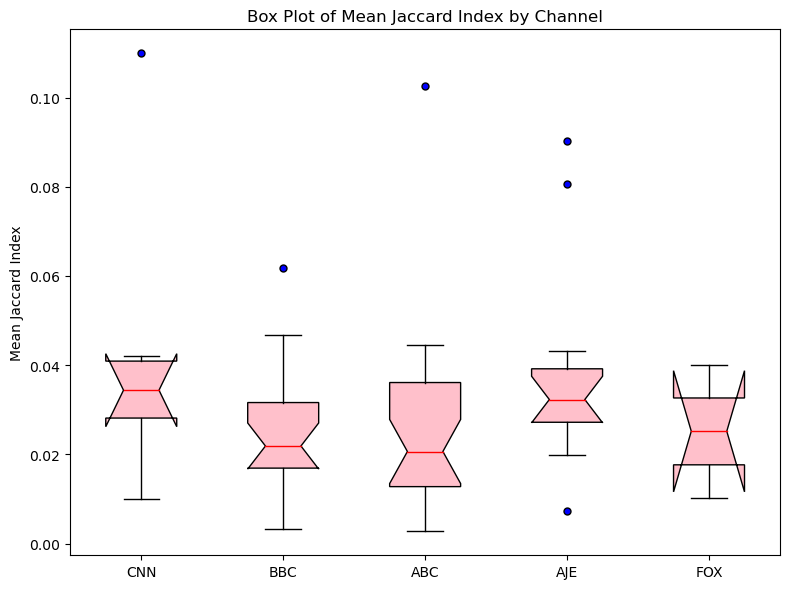

In [71]:
# Create a box plot for the data
data_list = [
    channel_averages['cnn'],   
    channel_averages['bbc'],   
    channel_averages['abc'],   
    channel_averages['aje'],   
    channel_averages['fox']  
]

channels = ["CNN", "BBC", "ABC", "AJE", "FOX"]

fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
ax.boxplot(data_list, vert=True, patch_artist=True, notch=True, 
           boxprops=dict(facecolor='pink'),
           flierprops=dict(markerfacecolor='blue', marker='o', markersize=5),
           medianprops=dict(color='red'))

ax.set_xticklabels(channels)
ax.set_ylabel("Mean Jaccard Index")
ax.set_title("Box Plot of Mean Jaccard Index by Channel")

plt.tight_layout()
plt.show()

#### Computing pairwise overlap between two bubbles of **different** channels

In [148]:
#extracting user_id for each bubble of each cluster

def extract_user_id (cluster, channel_name ):
    channel_bubbles_user_id = {}
    
    num_bubbles = len(set(labels_dict[channel_name]))  # Number of unique bubbles for this channel
    
    for i in range(num_bubbles-1):
        # Extract user IDs corresponding to the current bubble
        user_ids = list(cluster.author.iloc[(labels_dict[channel_name] == i).nonzero()])
        channel_bubbles_user_id[i] = user_ids
    
    return channel_bubbles_user_id

In [ ]:

def compute_pairwise_overlap(cluster, channel_name, labels_dict, bubbles_video_author_matrices):
    # Extract user id for each bubble
    channel_bubbles_user_id = extract_user_id(cluster, channel_name)
    
    # Initialize list to store the pairwise Jaccard means
    average_mean_jaccard_between = []
    
    # Number of bubbles for the current channel
    num_bubbles = len(channel_bubbles_user_id)
    
    # Compute pairwise overlap
    for i in range(num_bubbles):
        for j in range(i + 1, num_bubbles):  # Avoid double counting by starting j from i+1
            # Compute the Jaccard similarity between bubble i and bubble j
            average = dp.get_jacc_mean_between_two_clusters(
                bubbles_video_author_matrices[channel_name][i],
                bubbles_video_author_matrices[channel_name][j],
                pd.Series(channel_bubbles_user_id[i]),
                pd.Series(channel_bubbles_user_id[j])
            )
            average_mean_jaccard_between.append(average)
    
    return average_mean_jaccard_between


average_mean_jaccard_cnn_between = compute_pairwise_overlap(cluster_cnn, 'cnn', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_abc_between = compute_pairwise_overlap(cluster_abc, 'abc', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_bbc_between = compute_pairwise_overlap(cluster_bbc, 'bbc', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_aje_between = compute_pairwise_overlap(cluster_aje, 'aje', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_fox_between = compute_pairwise_overlap(cluster_fox, 'fox', labels_dict, bubbles_video_author_matrices)

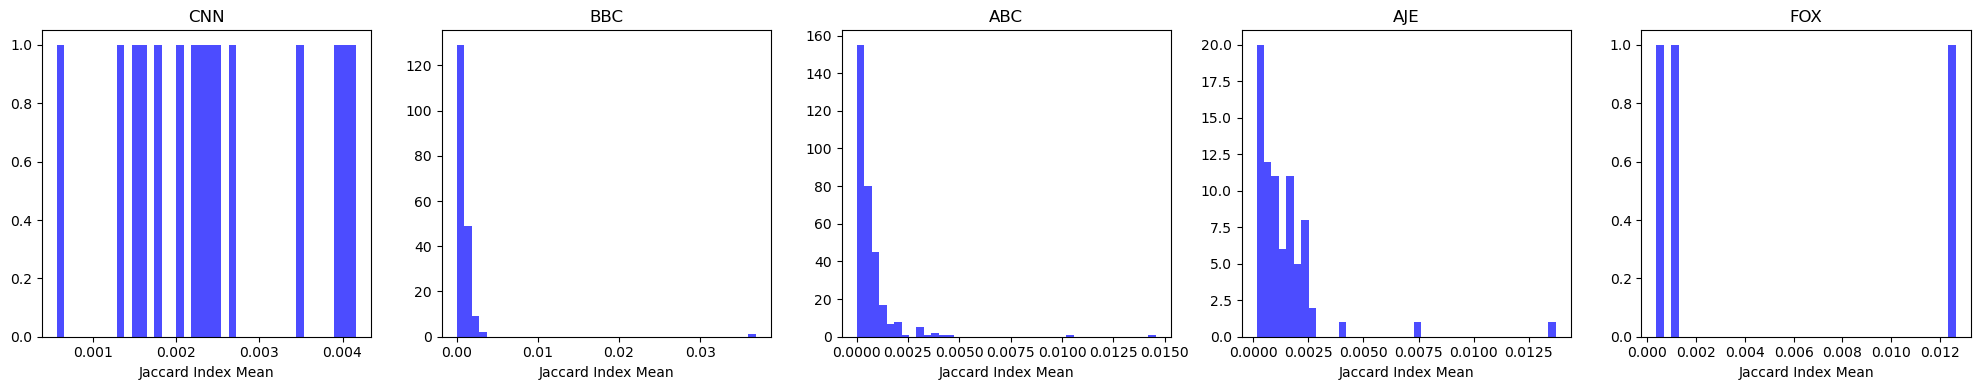

In [149]:
#mean jaccard index within bubble in a channel
data_list = [
    average_mean_jaccard_cnn_between,   
    average_mean_jaccard_bbc_between,   
    average_mean_jaccard_abc_between,   
    average_mean_jaccard_aje_between,   
    average_mean_jaccard_fox_between  
]

# Titles for each subplot
titles = ["CNN", "BBC", "ABC", "AJE", "FOX"]

# Create a figure with 5 subplots in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  

#plotting the whole
for i, (data, ax) in enumerate(zip(data_list, axes)):
    ax.hist(data, bins=40, color='blue', alpha=0.7)  
    ax.set_title(titles[i])  
    ax.set_xlabel("Jaccard Index Mean")  


# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()


### Calculating mean jaccard value table for the bubbles

#### For the main bubble of each cluster

In [ ]:
df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_main_bubbles_main_clusters.csv"

try:
    df_mean_jaccard_value_table_main_bubble_of_main_clusters = pd.read_csv(df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename,
                                                                           index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn_b0': extract_user_id(cluster_cnn, 'cnn')[0],
                         'abc_b0': extract_user_id(cluster_abc, 'abc')[0],
                         'bbc_b0': extract_user_id(cluster_bbc, 'bbc')[0],
                         'aje_b0': extract_user_id(cluster_aje, 'aje')[0],
                         'fox_b0': extract_user_id(cluster_fox, 'fox')[0],
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn_b0': bubbles_video_author_matrices['cnn'][0],
                             'abc_b0': bubbles_video_author_matrices['abc'][0],
                             'bbc_b0': bubbles_video_author_matrices['bbc'][0],
                             'aje_b0': bubbles_video_author_matrices['aje'][0],
                             'fox_b0': bubbles_video_author_matrices['fox'][0],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn_b0', 'abc_b0', 'bbc_b0', 'aje_b0', 'fox_b0', 'rdm'])
                         for name2 in ['cnn_b0', 'abc_b0', 'bbc_b0', 'aje_b0', 'fox_b0', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_main_bubbles_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                             users_in_clusters,
                                                                                             jaccard_filenames,
                                                                                             df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename)

display(df_mean_jaccard_value_table_main_bubbles_main_clusters)

sns.heatmap(df_mean_jaccard_value_table_main_bubbles_main_clusters, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of main bubbles of different clusters")

Comparing the average jaccard index , which is indicative of the pairwise overlapping, between the bubbles and the one within the bubbles for each channels, we  see that for each the overlap is quite low as expected. Furthermore as expected the users overlap between the bubbles in a channel is much lower (factor of 10) than the overlap of users within a bubble. This shows that the bubbles are correctly clustered and doesnt overlap each other in a channel. Users interested by similar videos dont really mix with users in other clusters having other interests. 

# Part 4: Content of the videos 

In [4]:
#loading videos_new_pol
video_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"
videos_new_pol = pd.read_csv(video_filepath)

In [14]:
# Bubbles
bubbles_channels = {
    'CNN': video_author_matrix_cnn_cluster,
    'BBC': video_author_matrix_bbc_cluster,
    'ABC': video_author_matrix_abc_cluster,
    'AJE': video_author_matrix_aje_cluster,
    'FOX': video_author_matrix_fox_cluster
}

main_channel_ids = {
    'CNN': channel_id_cnn,
    'BBC': channel_id_bbc,
    'AJE': channel_id_aje,
    'FOX': channel_id_fox,
    'ABC': channel_id_abc
}

## What are the main videos our bubbles look at ? Are they related to their channel for the big bubbles ? 

### Pie chart of media repartition for each cluster

We want to verify if the commenters in our clusters actually diversify their sources. That's why we are plotting a pie chart for each cluster, showing the repartition of commented videos by the cluster's members between the several News and Politics channels. We can set a threshold if we want to take into account videos that have been commented by a certain percentage of the cluster e.g. set the threshold at 1% if you want to see the repartition of videos that have been commented by at least 1% of the cluster's members.

679447 out of 679447 total viceos commented are taken into account in this pie chart


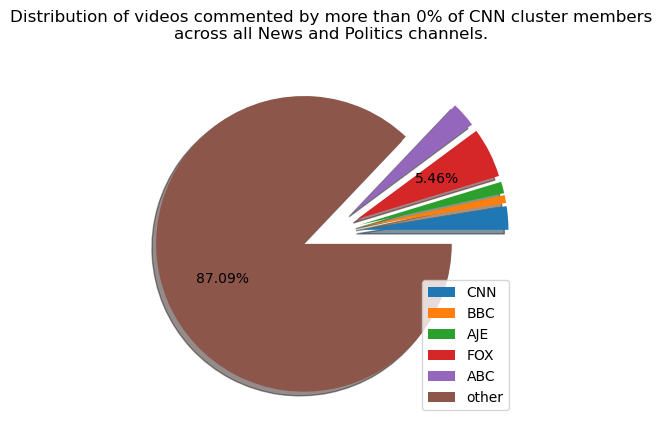

679921 out of 679921 total viceos commented are taken into account in this pie chart


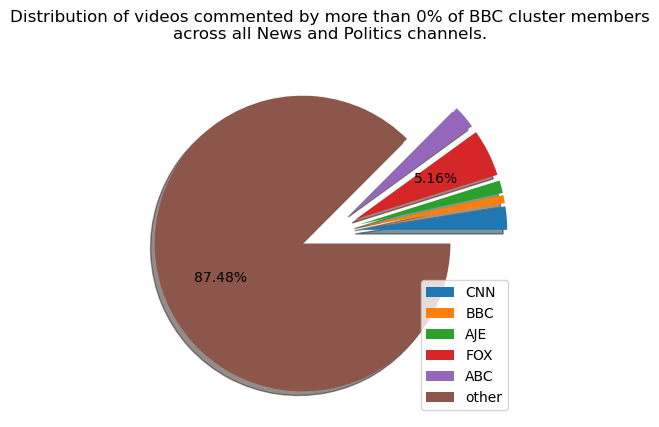

737843 out of 737843 total viceos commented are taken into account in this pie chart


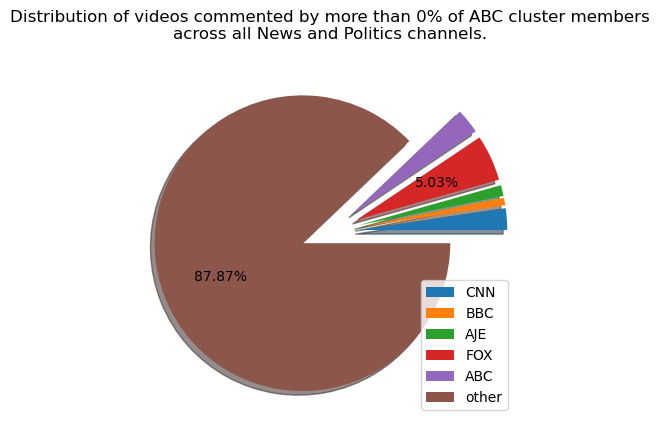

589119 out of 589119 total viceos commented are taken into account in this pie chart


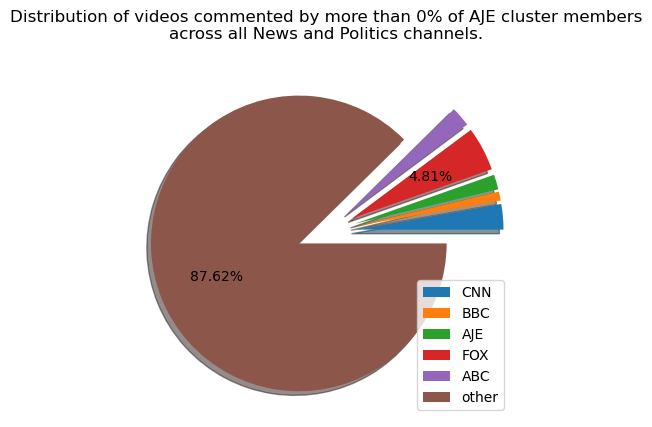

654572 out of 654572 total viceos commented are taken into account in this pie chart


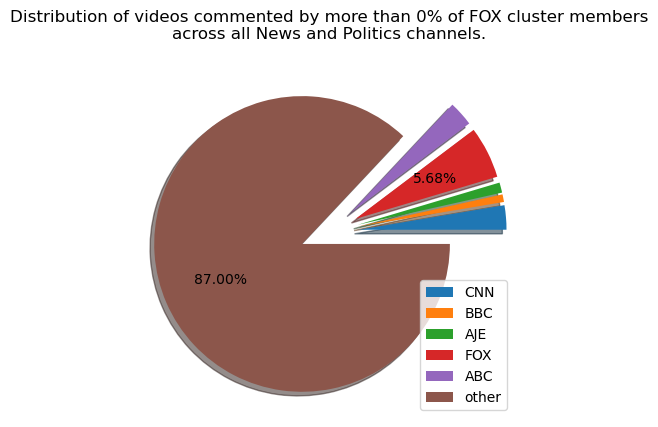

13504 out of 679447 total viceos commented are taken into account in this pie chart


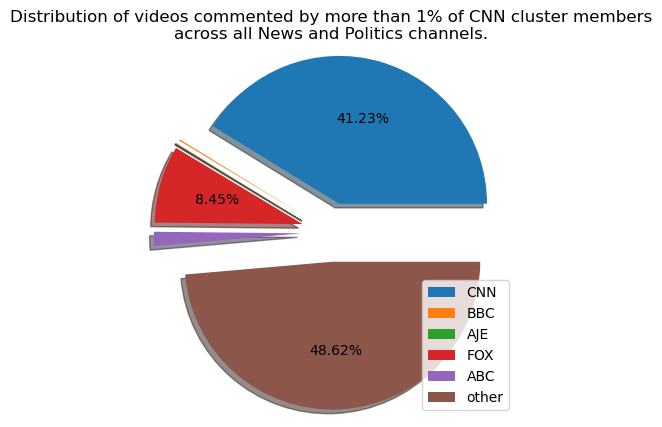

3559 out of 679921 total viceos commented are taken into account in this pie chart


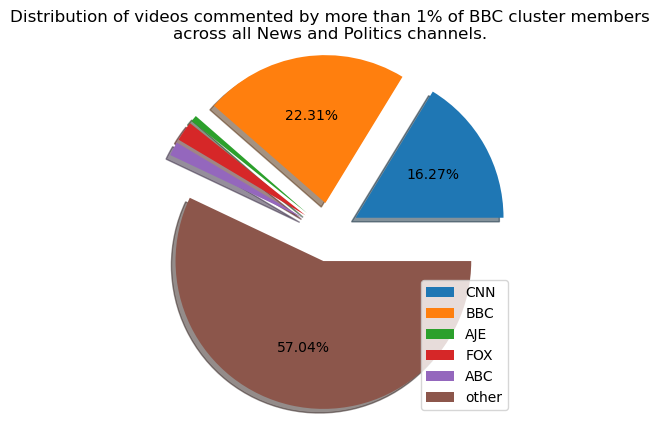

4518 out of 737843 total viceos commented are taken into account in this pie chart


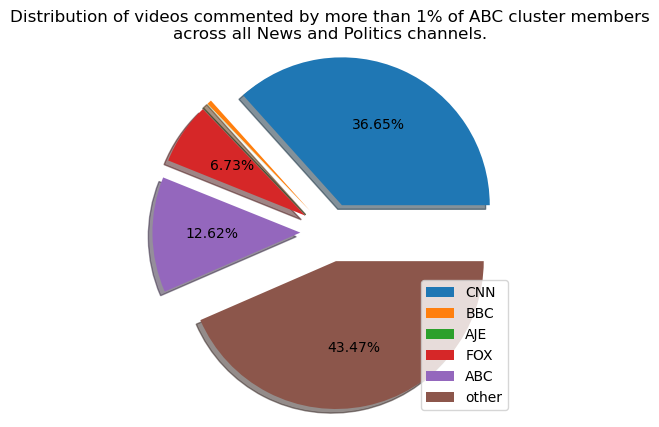

4770 out of 589119 total viceos commented are taken into account in this pie chart


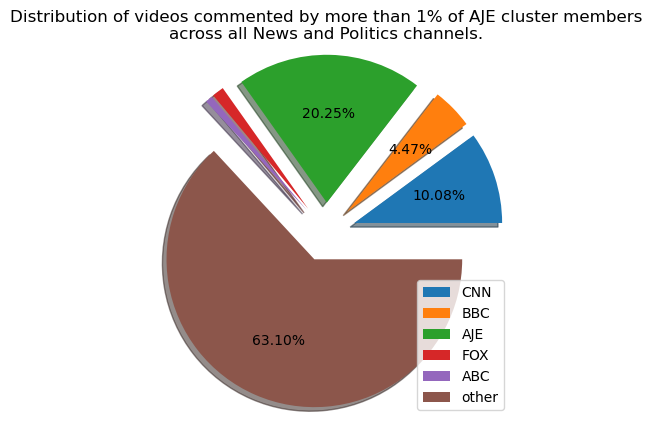

15198 out of 654572 total viceos commented are taken into account in this pie chart


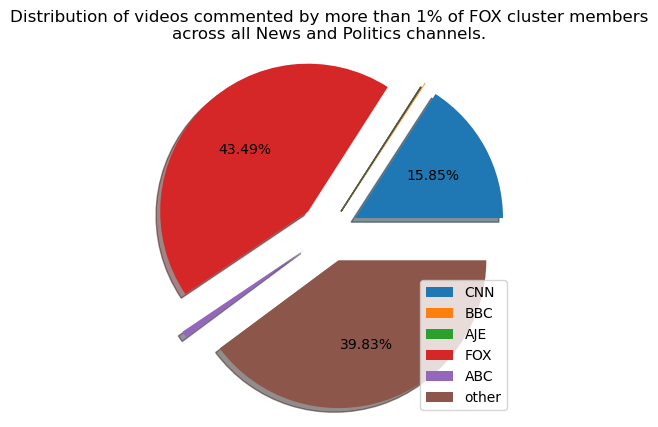

In [20]:
#plotting a pie chart for each cluster of the repartition of commented videos depending on which channel they are from
dp.pie_chart_repartition_media(bubbles_channels , main_channel_ids, videos_new_pol) #no threshold


dp.pie_chart_repartition_media(bubbles_channels , main_channel_ids, videos_new_pol, 0.01) #thershold of 1%

## But what do the videos talk about ? Can we find the most popular subject based on the title?

### Looking at cluster bubbles : cnn, abc, bbc, aje, fox

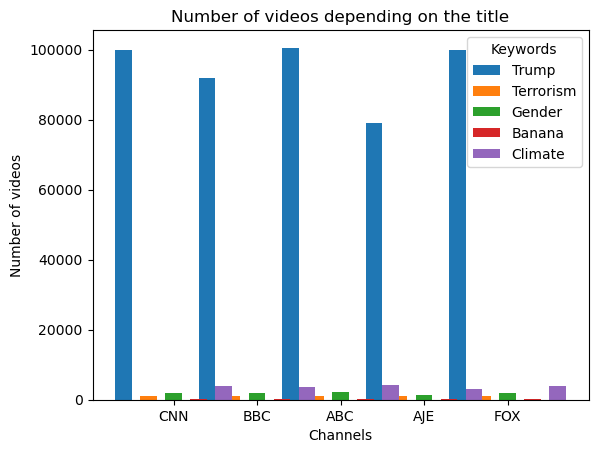

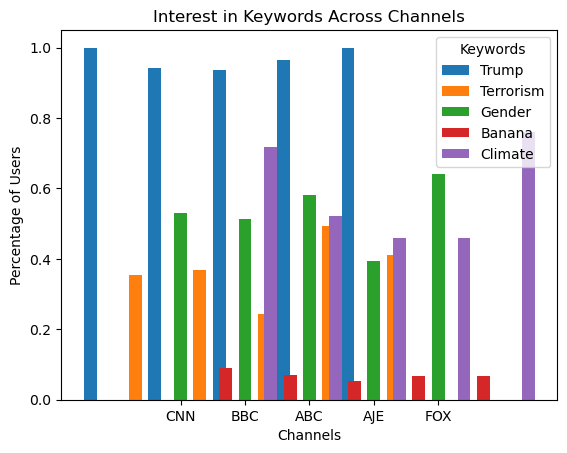

In [74]:
keywords = ['Trump', 'Terrorism', 'Gender', 'Banana', 'Climate']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


## ANALYSIS


--> Trump has way way more videos then the rest of the chosen word, we excluded it because it's too much.
Trump seems to be a main topic between all clusters.
Also, almost all users has commented under at least one video who title has Trump in its title __> shows the great interest of internaut for the man. Compared to it, more general topics as terrorism or climate is less seen, but still research.
Funny joke for banana word, and also control sample, which shows that this word is less titled, BUT still hundred of videos has this word in its title!!

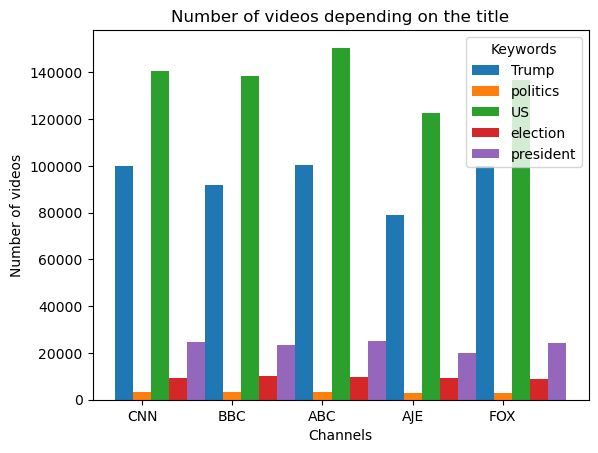

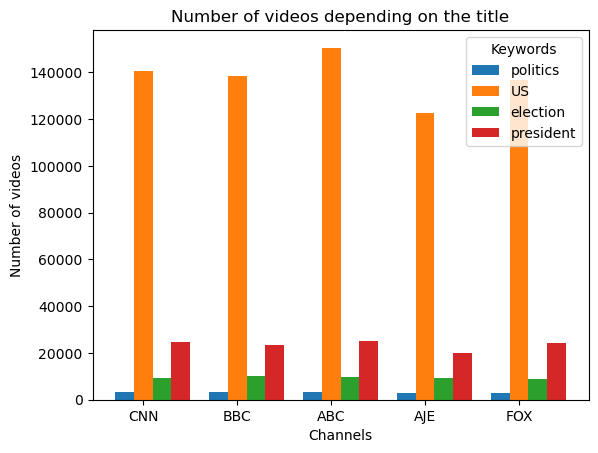

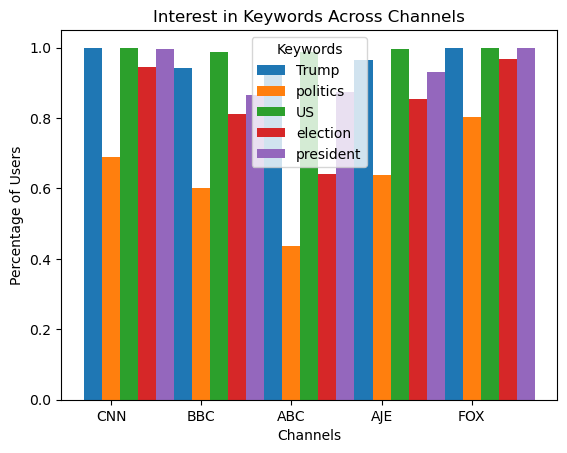

In [154]:
keywords = ['Trump', 'politics', 'US', 'election', 'president']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


## ANALYSIS

we decide to took related words in order to see how muh it is utilized by users, and no surprise, the related politics words seems to have more then half of it users that has commented under at least one of the videos that has one of the chosen word in its title. 
Have to blablabla ?

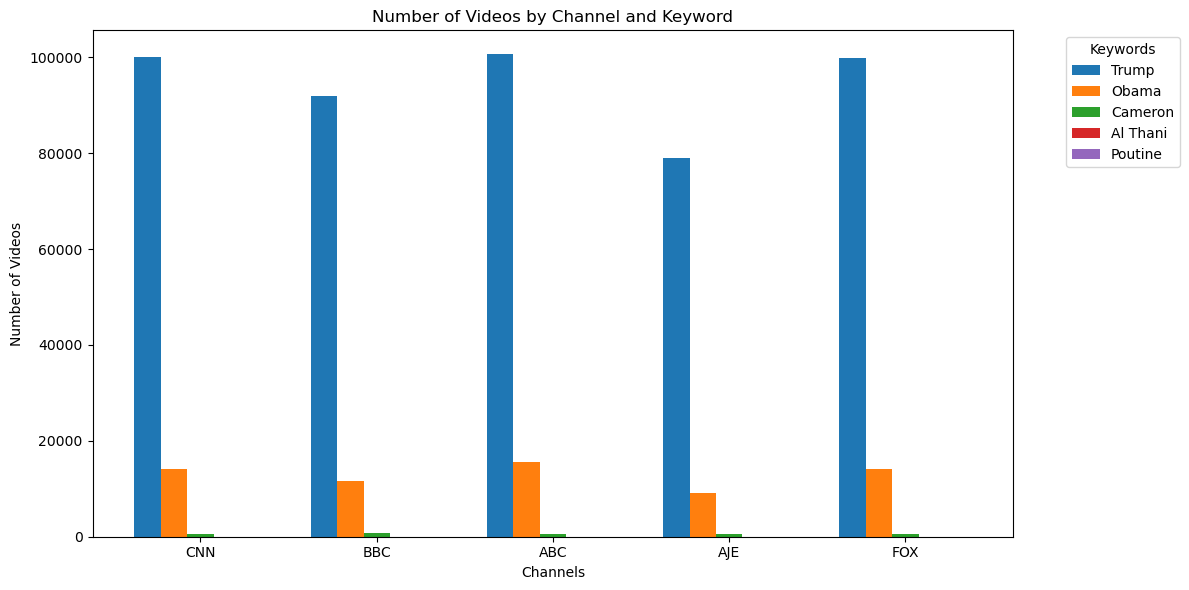

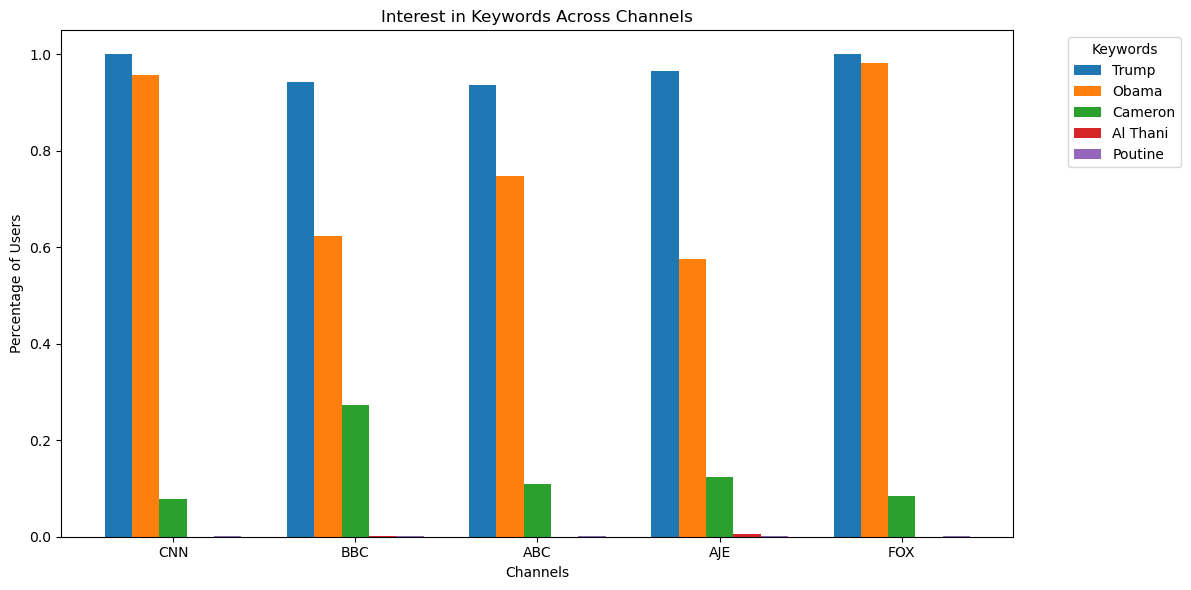

In [114]:
#Popularity 
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


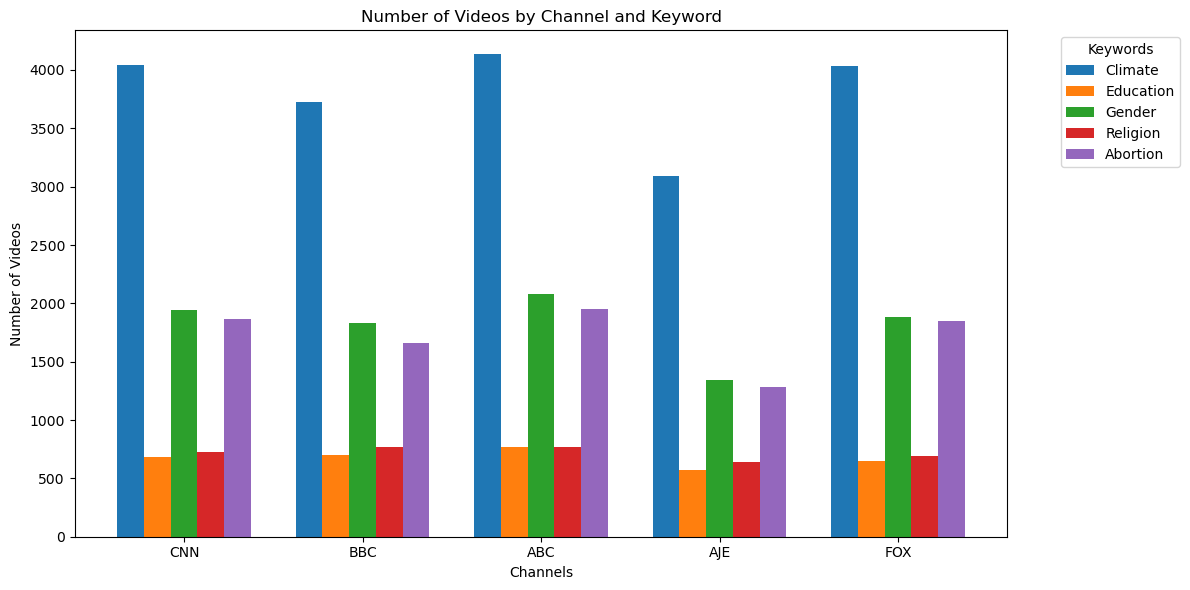

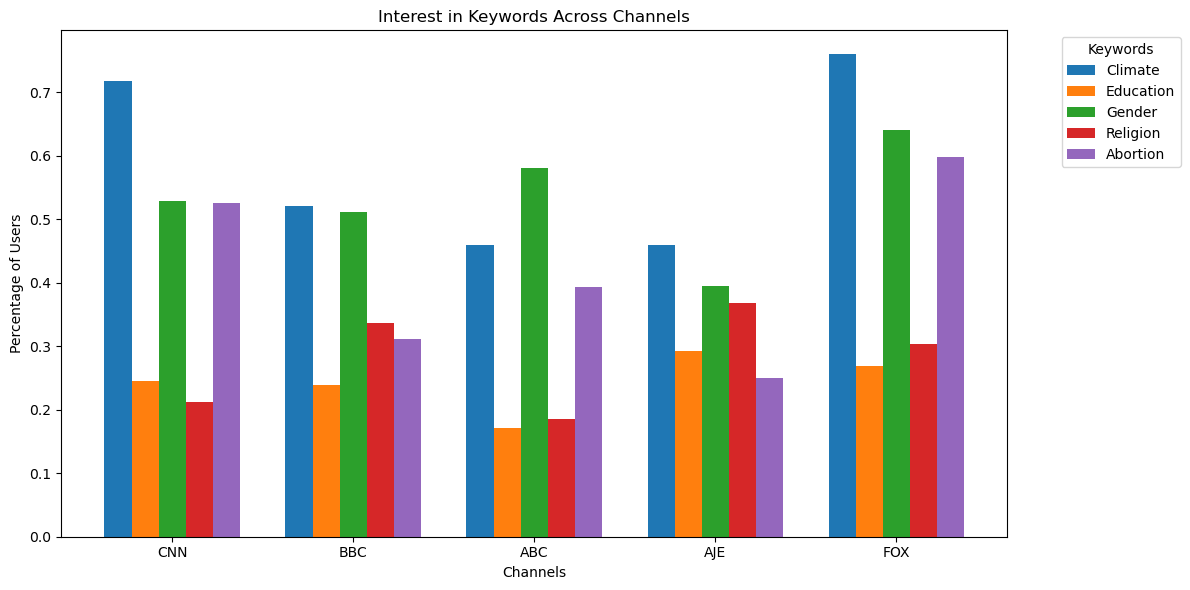

In [115]:
#Category
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

# Looking at bubbles within a cluster

In [117]:
#CNN

bubbles_cnn = {

    'bubble 1': bubbles_video_author_matrices['cnn'][0],
    'bubble 2':  bubbles_video_author_matrices['cnn'][2],
    'bubble 3':  bubbles_video_author_matrices['cnn'][5],
}

#ABC

bubbles_abc = {

    'bubble 1': bubbles_video_author_matrices['abc'][0],
    'bubble 2':  bubbles_video_author_matrices['abc'][3],
    'bubble 3':  bubbles_video_author_matrices['abc'][6],
}

#BBC

bubbles_bbc = {

    'bubble 1': bubbles_video_author_matrices['bbc'][0],
    'bubble 2':  bubbles_video_author_matrices['bbc'][6],
    'bubble 3':  bubbles_video_author_matrices['bbc'][8],
}

#AJE

bubbles_aje = {

    'bubble 1': bubbles_video_author_matrices['aje'][0],
    'bubble 2':  bubbles_video_author_matrices['aje'][2],
    'bubble 3':  bubbles_video_author_matrices['aje'][3],
}

#Fox

bubbles_fox = {

    'bubble 1': bubbles_video_author_matrices['fox'][0],
    'bubble 2':  bubbles_video_author_matrices['fox'][1],
    'bubble 3':  bubbles_video_author_matrices['fox'][2],
}


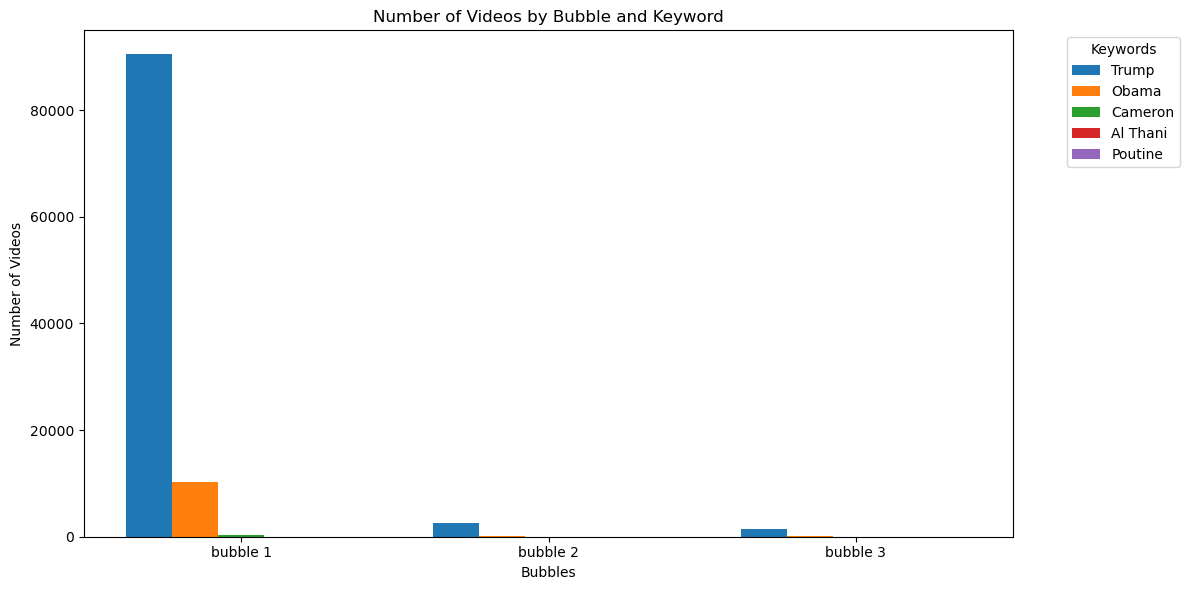

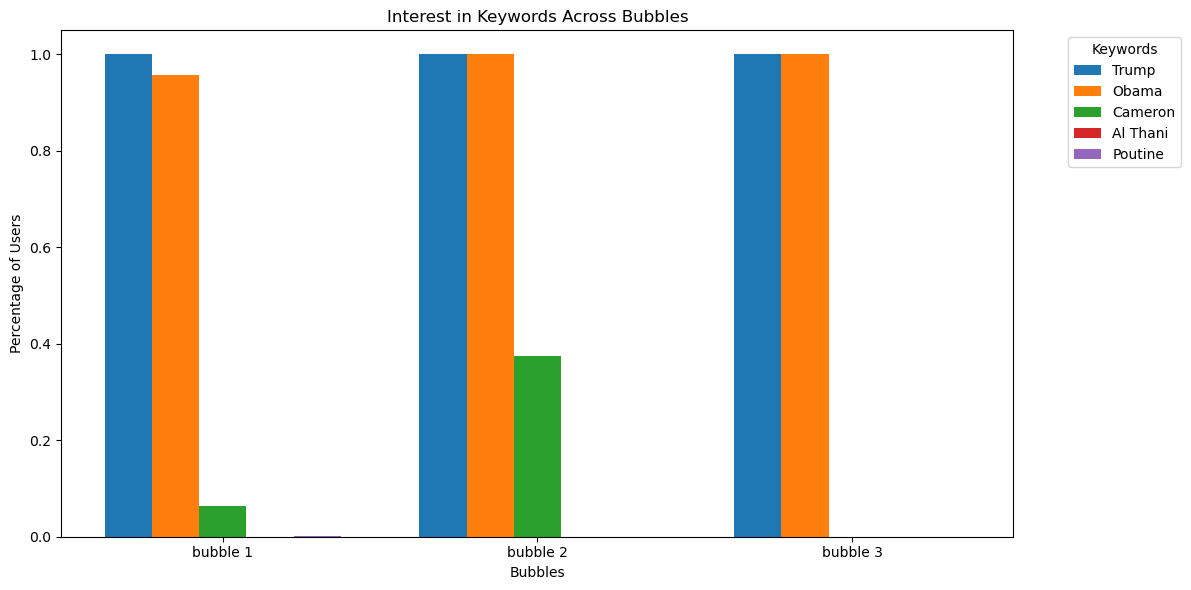

In [128]:
#Popularity 

#CNN
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


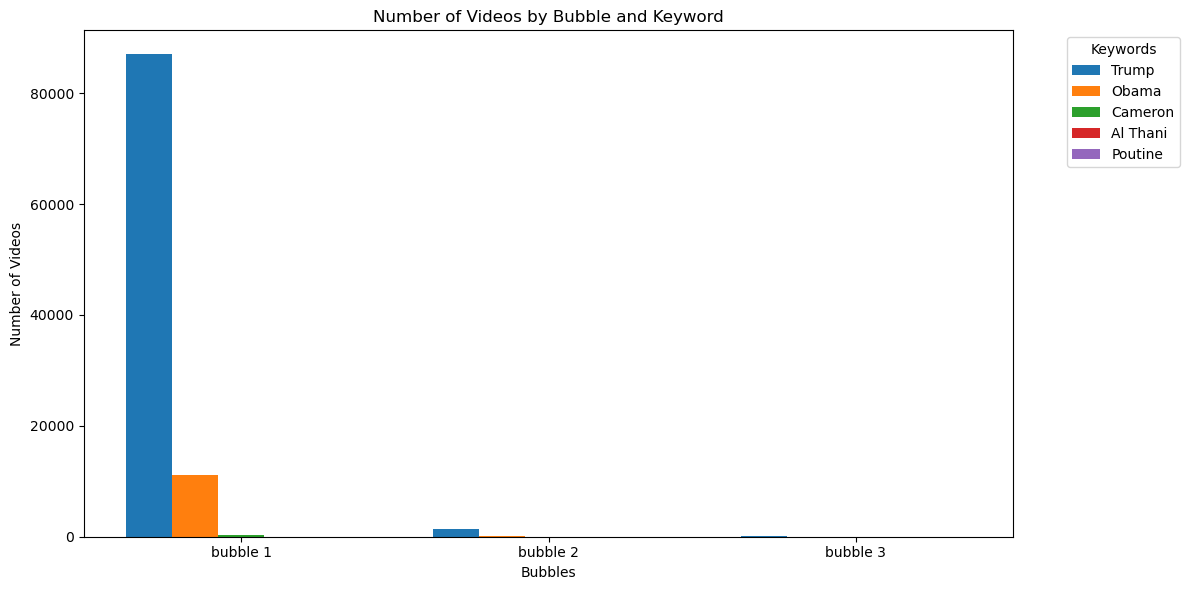

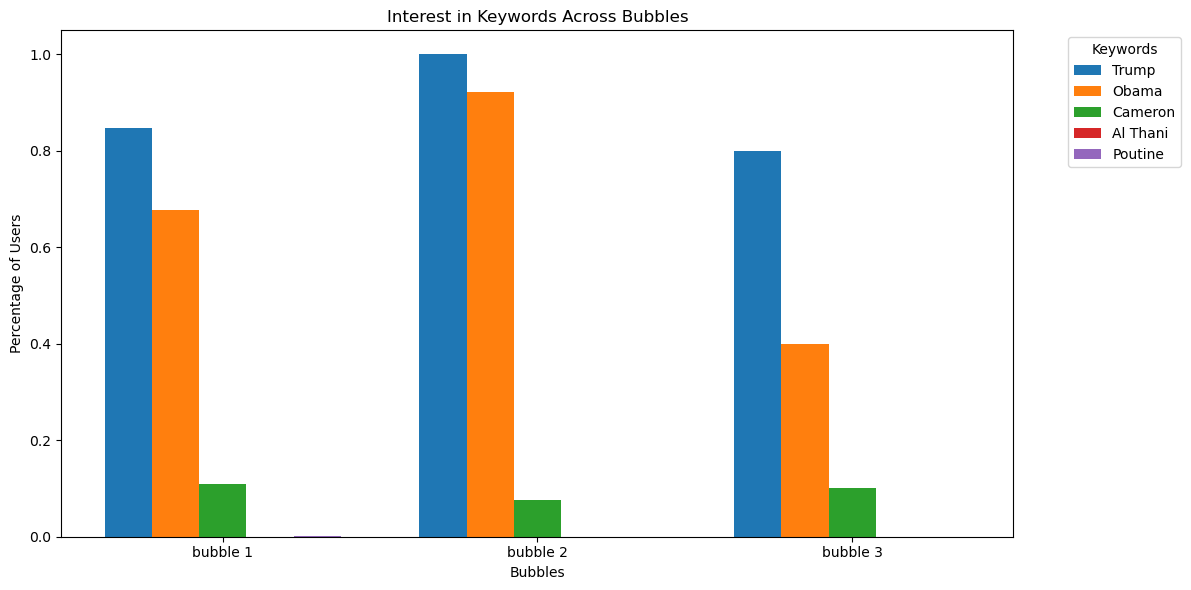

In [129]:
#ABC
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


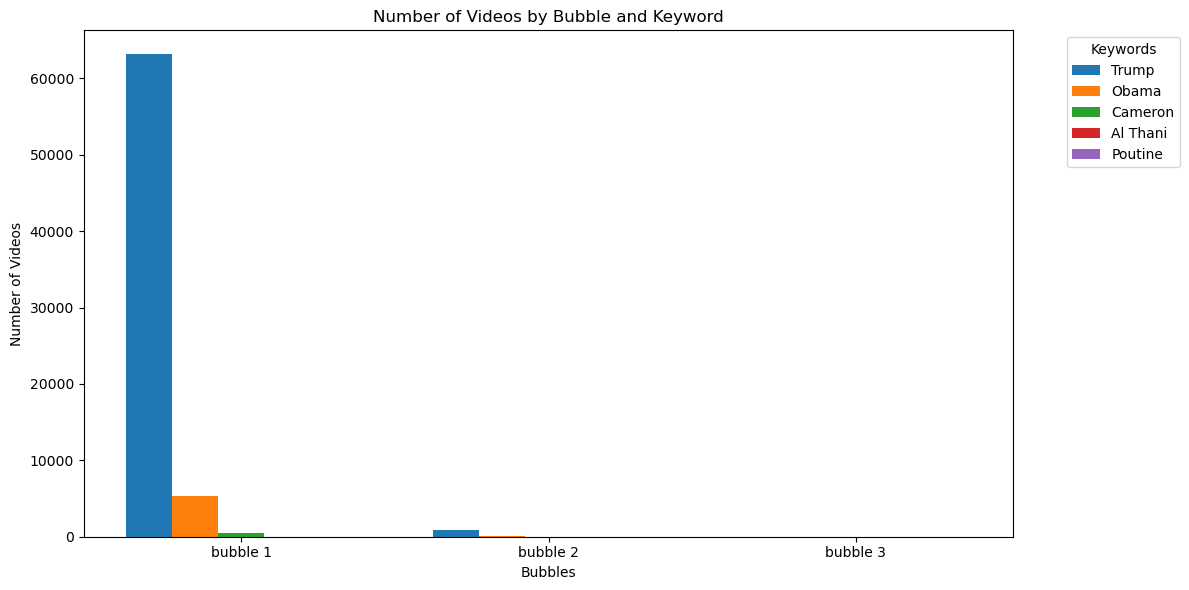

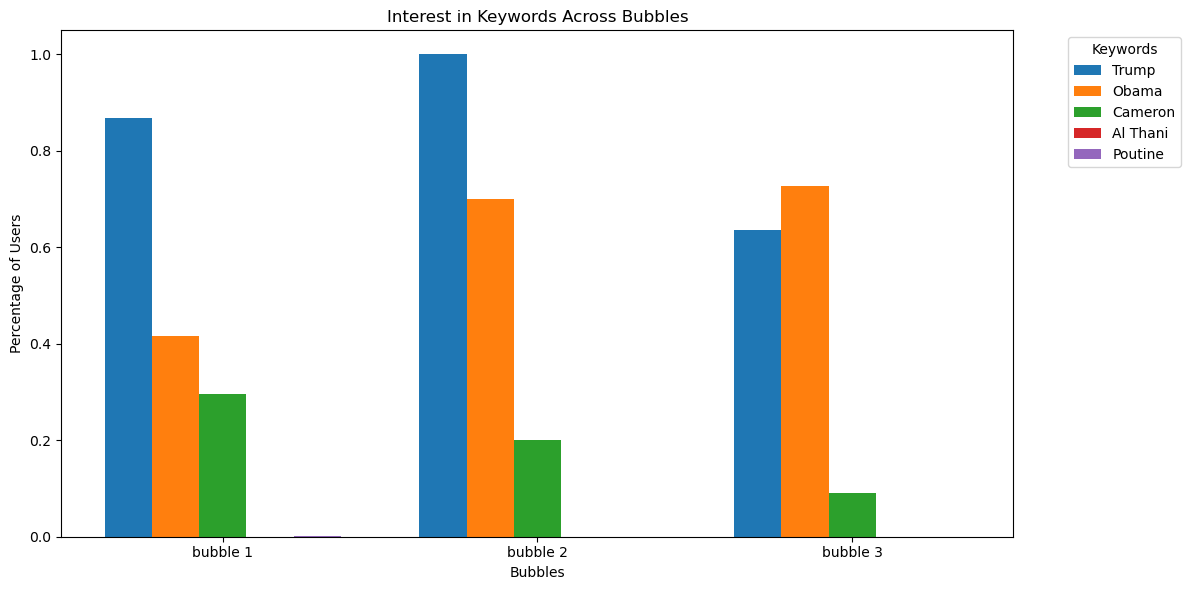

In [130]:
#BBC
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_bbc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


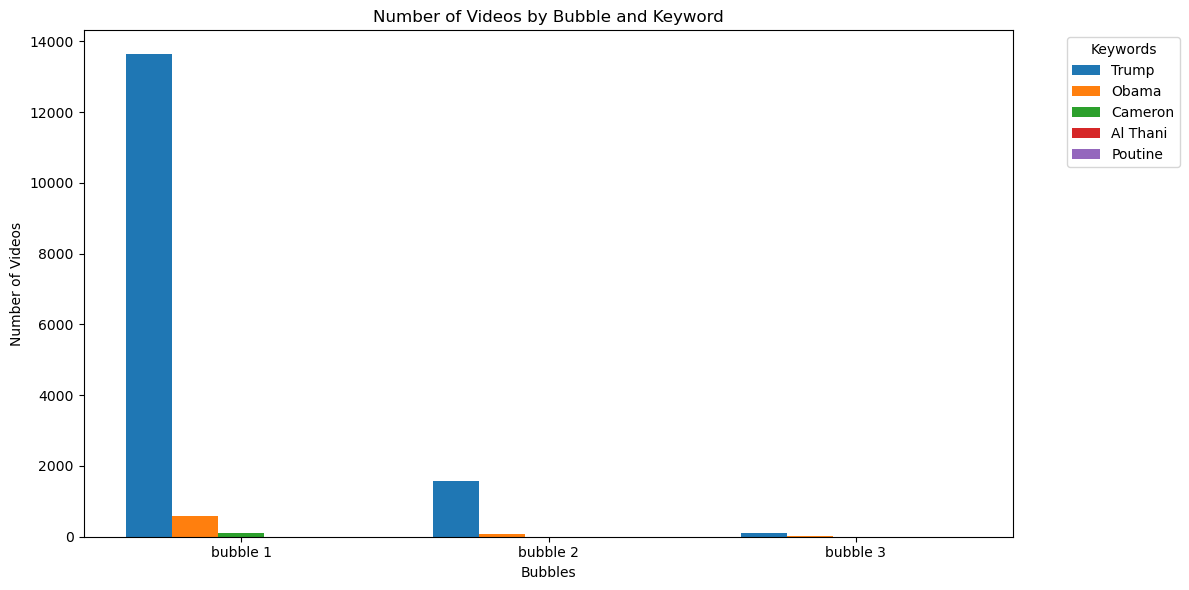

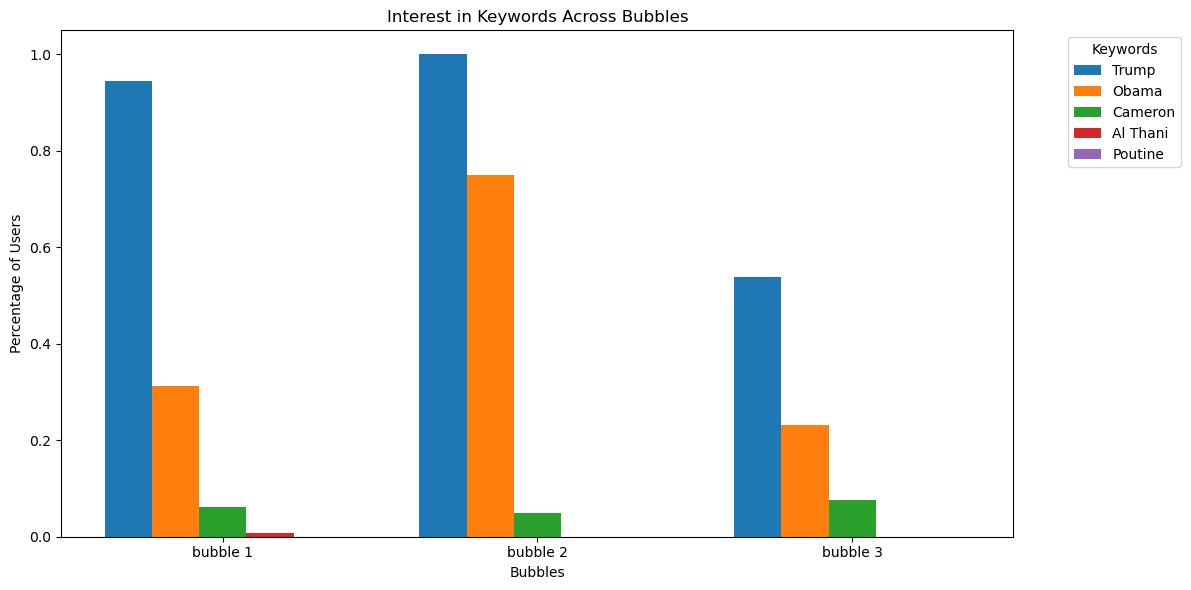

In [131]:
#AJE
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


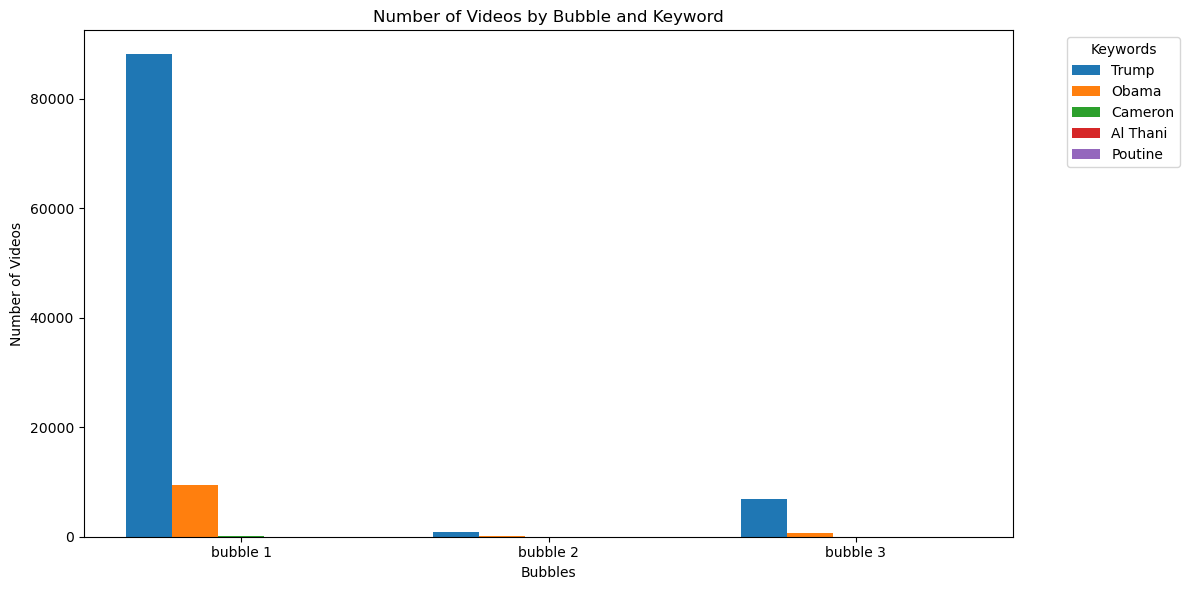

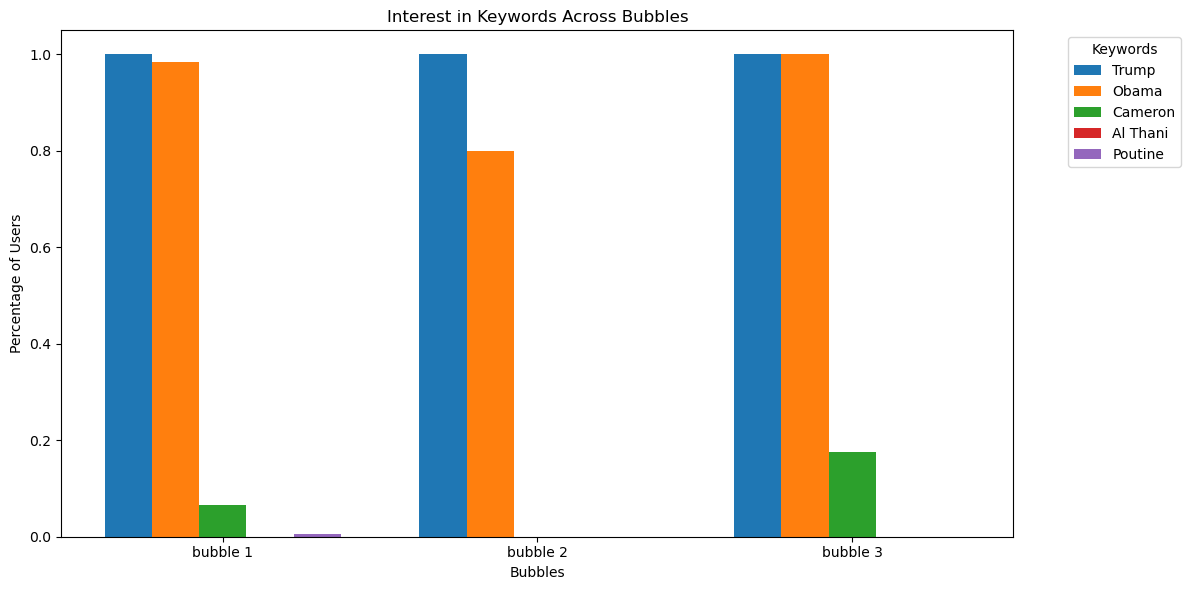

In [132]:
#Fox
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


### What about the different categories ?

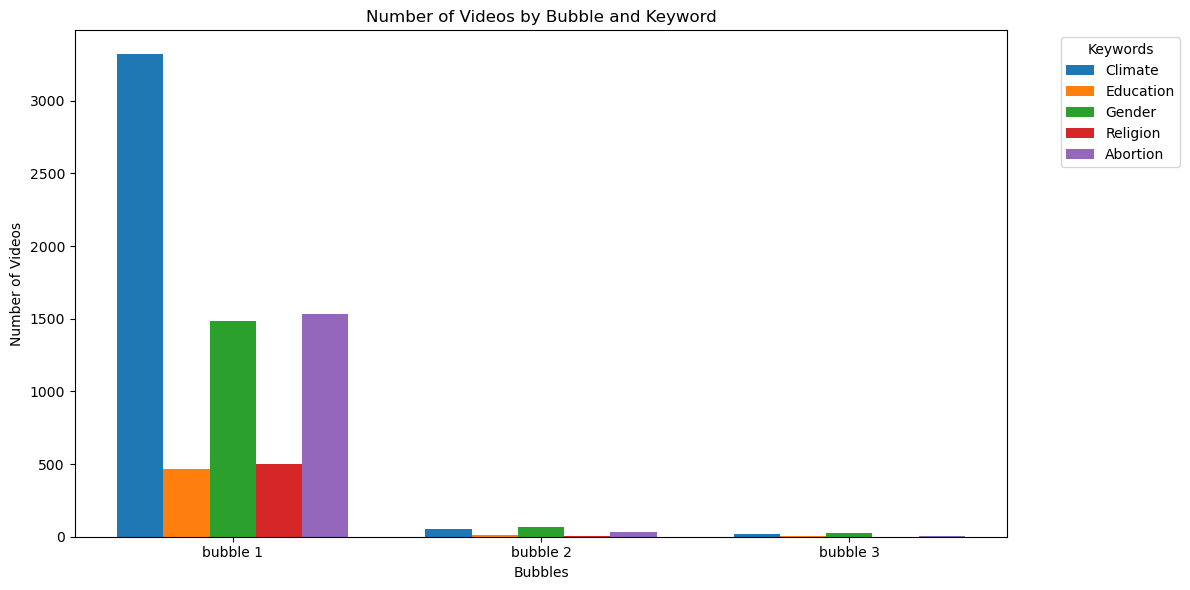

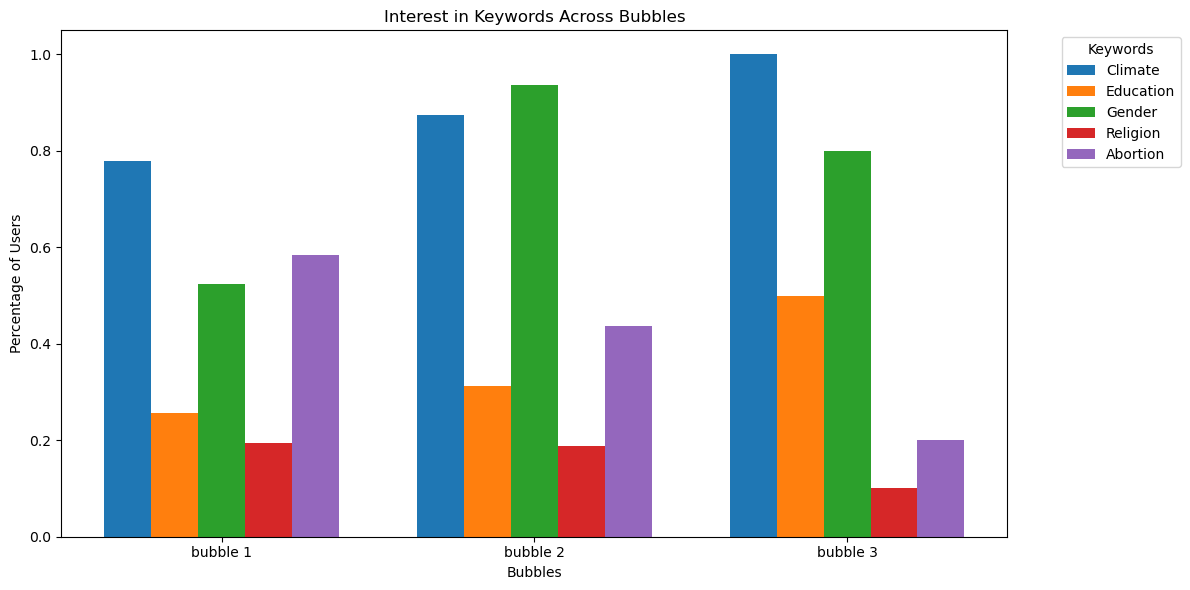

In [133]:
#Popularity 

#CNN
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


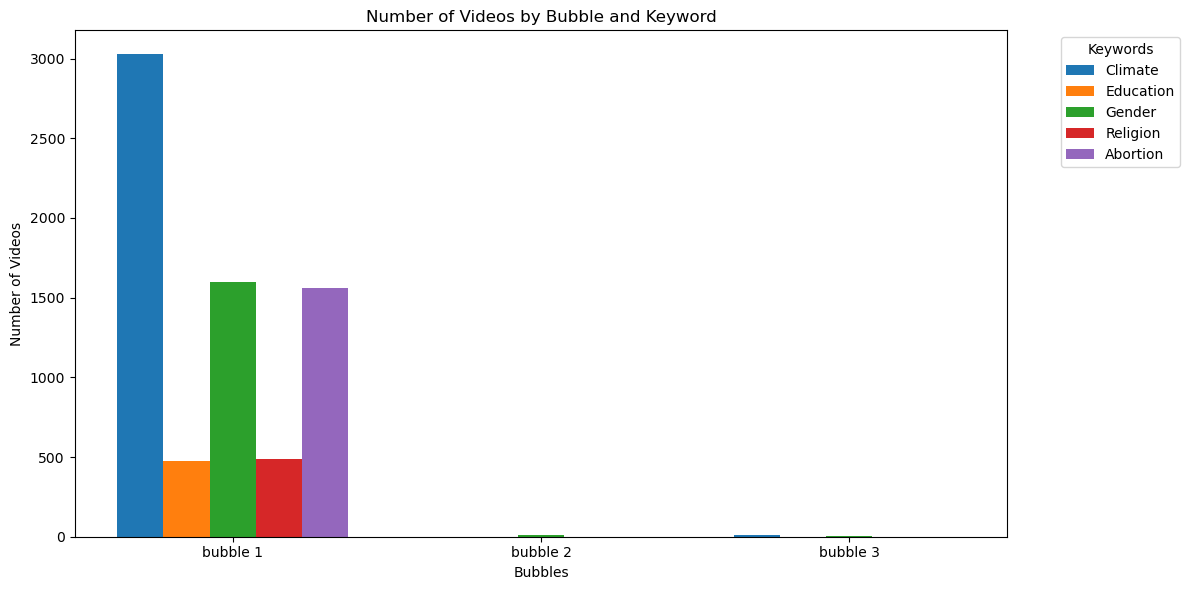

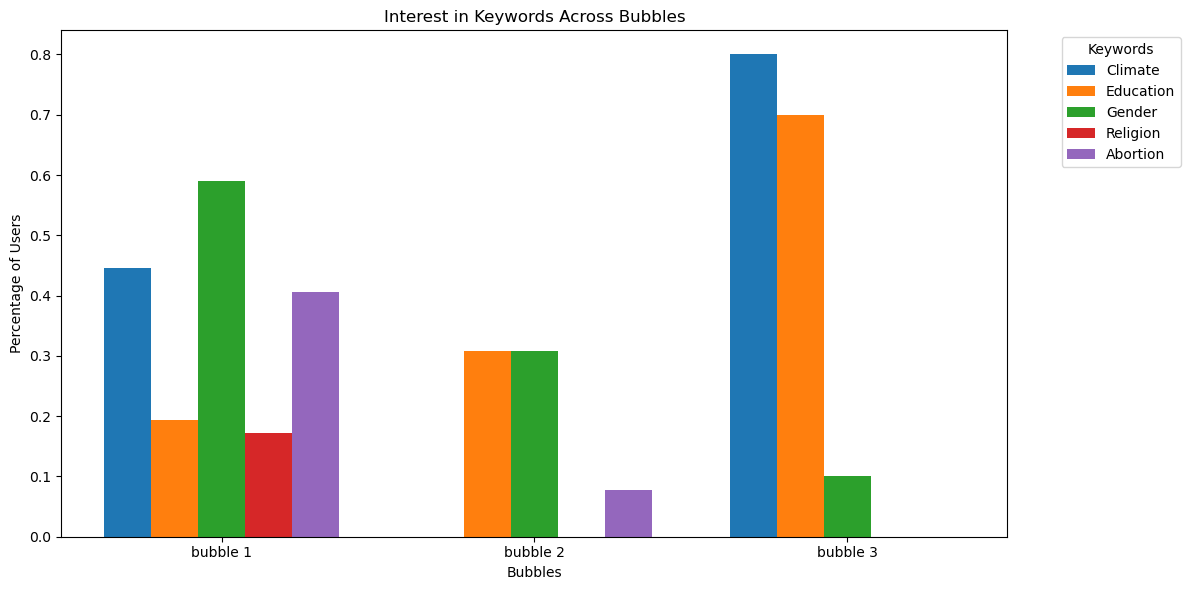

In [134]:
#ABC
keywords =['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


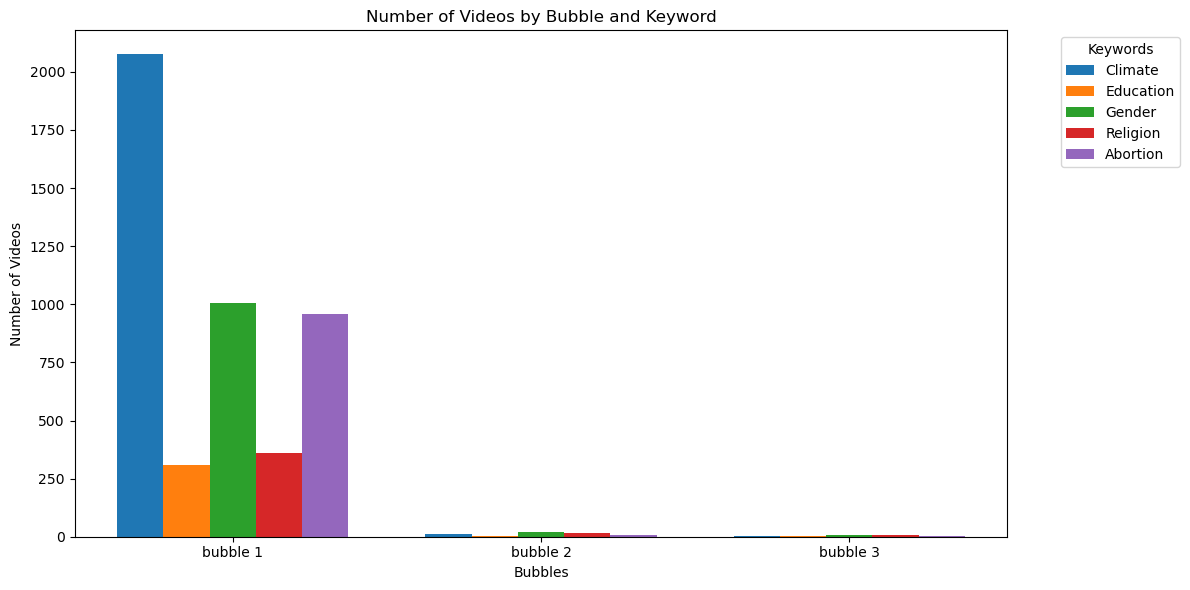

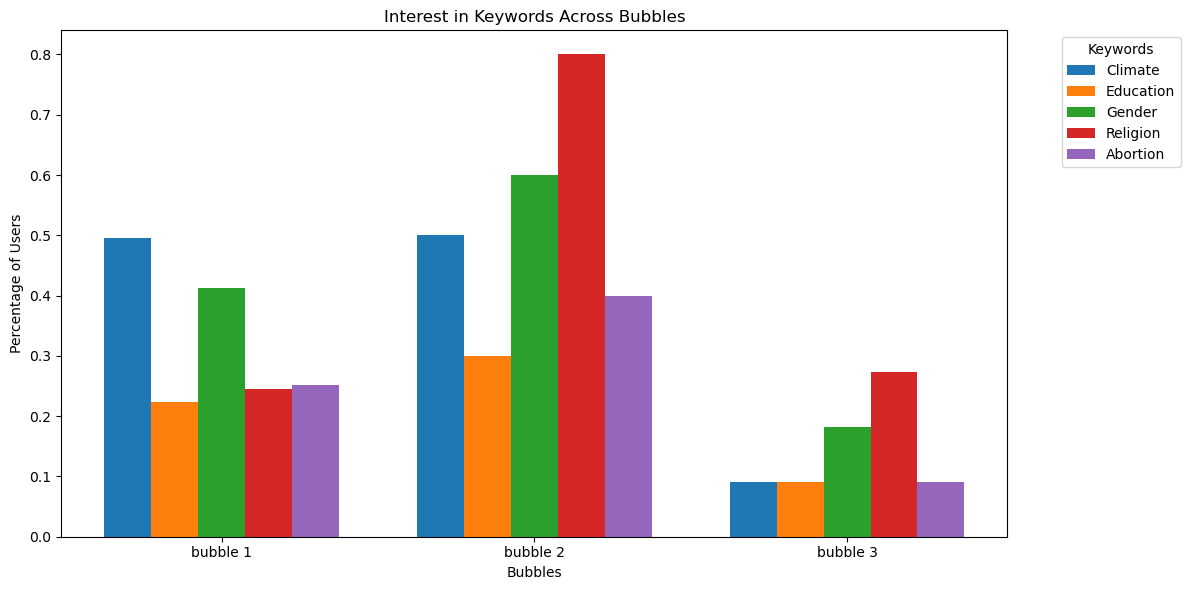

In [135]:
#BBC
keywords =['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_bbc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


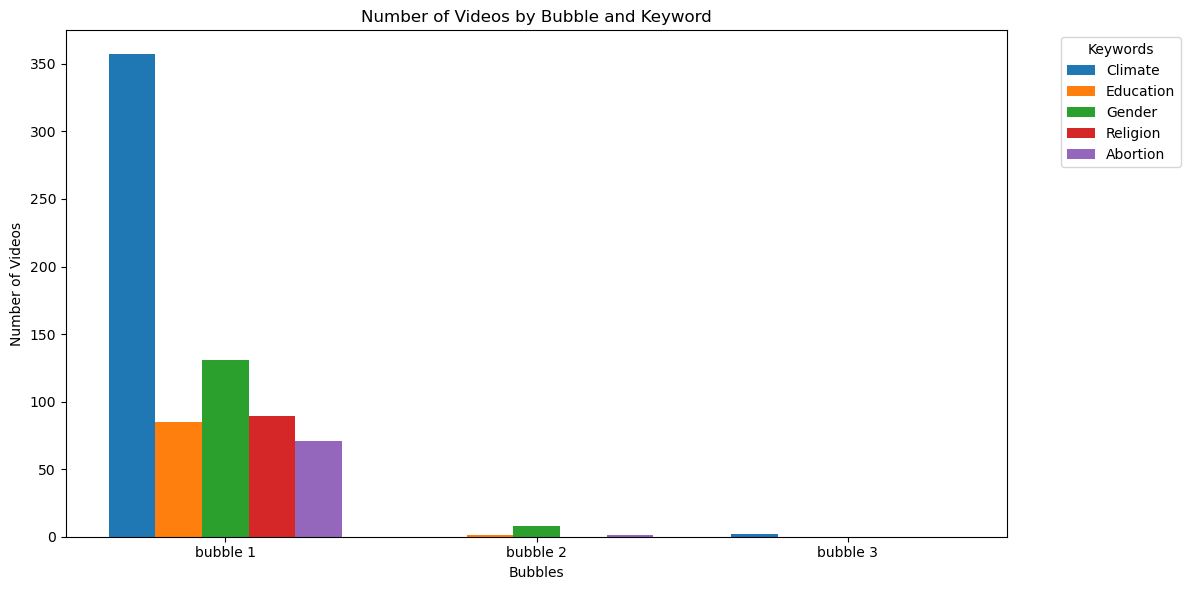

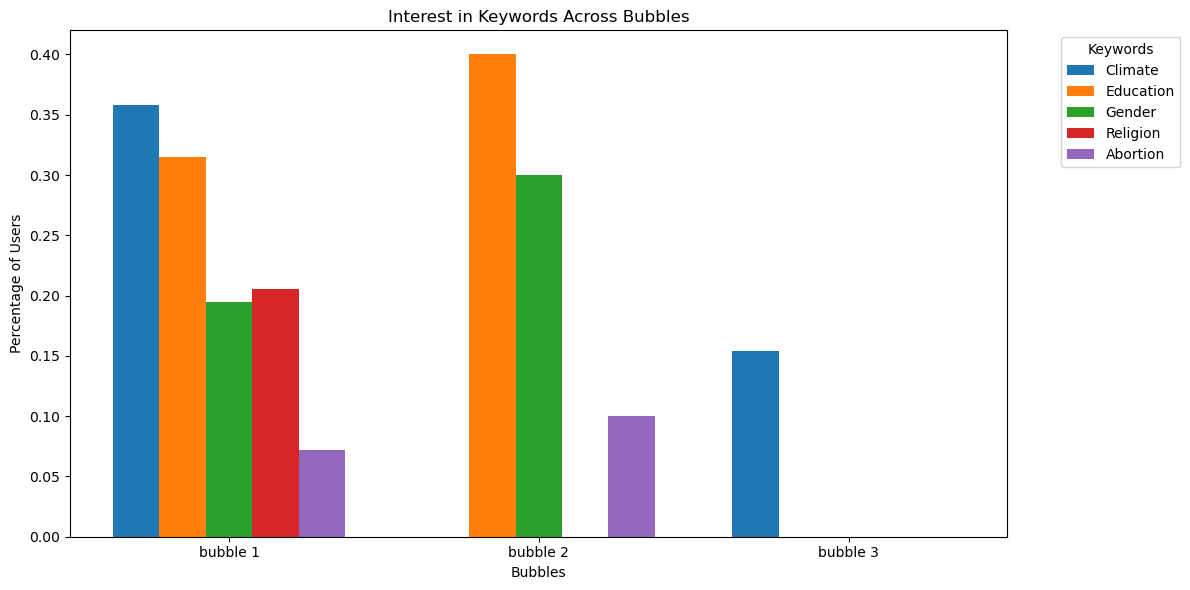

In [136]:
#AJE
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


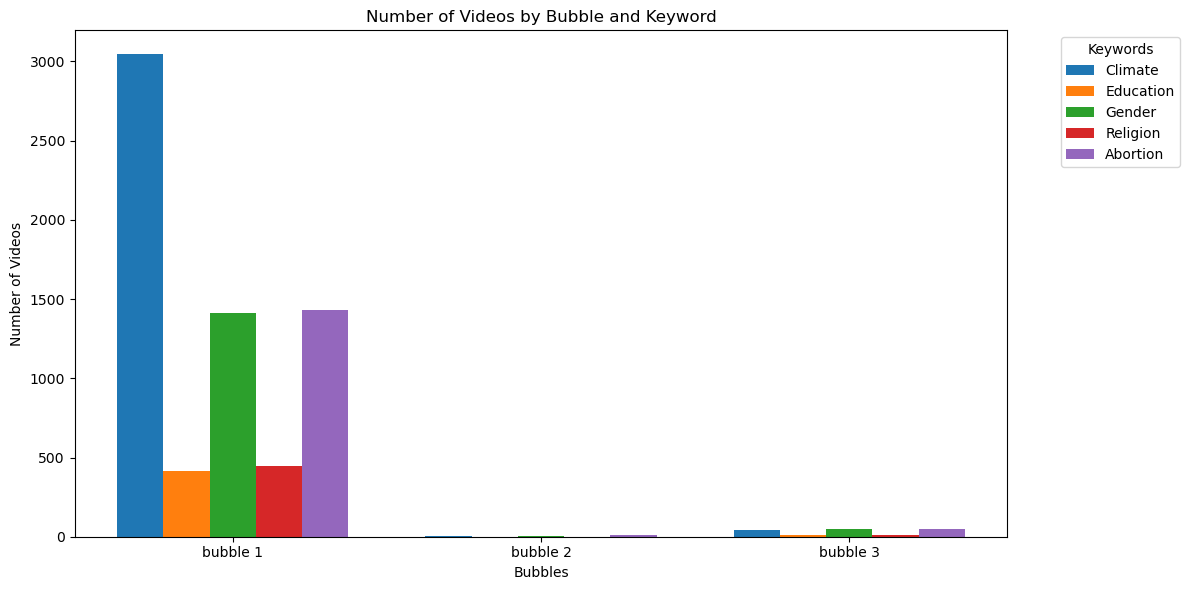

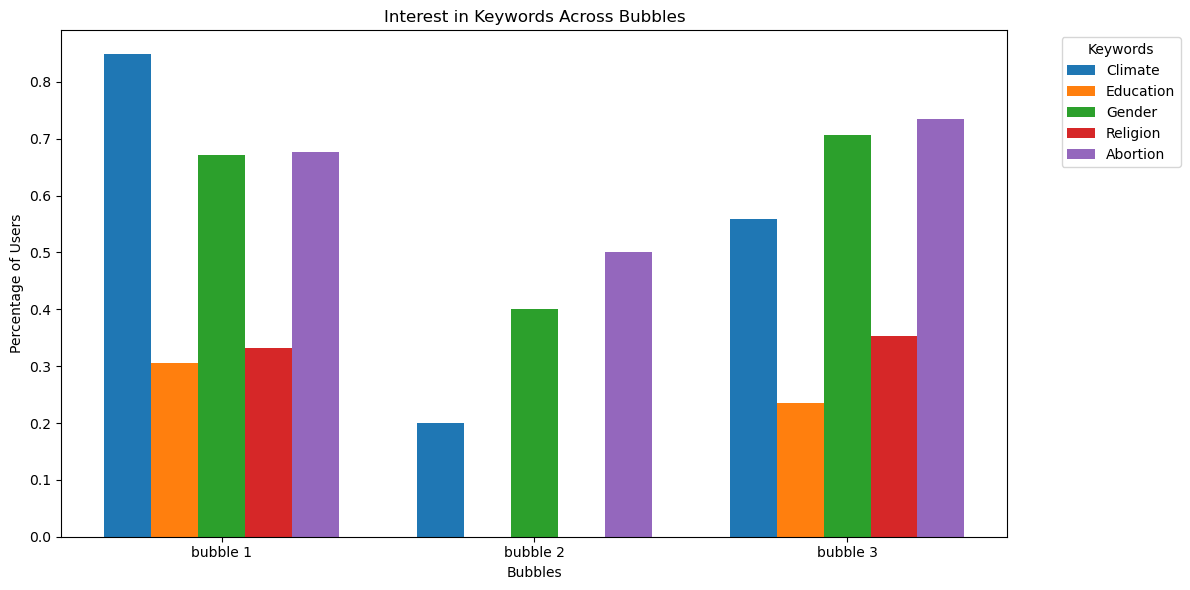

In [137]:
#Fox
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)
